In [2]:
library(stringr)
library(ggplot2)
library(RColorBrewer)
library(dplyr)
library(reshape2)
library(tibble)
library(gplots)
library(ggfortify)
library(Rtsne)
library(ggpubr)

theme_set(theme_minimal())
theme_update(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
theme_update(text = element_text(size = 17))

#Functions

get_genus <- function(taxon_string){
    if(taxon_string == "") {
        ret = NA } else {
    bacs = str_split(taxon_string, ",")[[1]]
    ret = unlist(unique(lapply(str_split(bacs,"/"),`[[`, 5)))[1]
    if(grepl("acteroides", ret, fixed=TRUE)) ret = "Bacteroides_mix"
        }
    return (ret)
    }

get_phylum <- function(taxon_string){
    if(taxon_string == "") {
        ret = NA } else {
    bacs = str_split(taxon_string, ",")[[1]]
    ret = unlist(unique(lapply(str_split(bacs,"/"),`[[`, 1)))[1]
        }
    return (ret)
    }

my_hm_funtion = function(annotate_phage, annotate_sample, lib, value_var, max_vals = 5) {
    options(repr.plot.width=29, repr.plot.height=17)
    hmcol = colorRampPalette(brewer.pal(9, "BrBG"))(100)
    #hmcol = colorRampPalette(brewer.pal(9, "Blues"))(100)

    phar %>% subset(library == lib) %>% 
    arrange(GPD_VC) %>% mutate(taxon_id = paste(taxon_id,GPD_VC)) %>%
    mutate(taxon_id = factor(taxon_id, levels = unique(taxon_id))) -> hm_df
    hm_df %>% select(sample, one_of(annotate_sample)) %>% distinct() %>% column_to_rownames("sample") -> moi
    hm_df %>% select(taxon_id, one_of(annotate_phage)) %>% distinct() %>% column_to_rownames("taxon_id") -> pmoi
    hm_df %>% dcast(sample ~ taxon_id, value.var=value_var) %>% 
    column_to_rownames("sample") %>% as.matrix() %>%
    heatmap.2(dendrogram ="none", trace="none",Rowv = TRUE, Colv = TRUE,
            scale= "none",
             hclustfun=function(c){hclust(c, method="mcquitty")},
             lmat = rbind(c(0,5,0),c(0,2,0),c(1,3,4),c(0,6,0)), lwid = c(0.1,4,1), lhei = c(0.1,0.1,2,0.4), margins=c(15,5), # layout sizes
             key.title =NA, symkey = FALSE, key=TRUE,
             col=hmcol, breaks = seq(-max_vals, max_vals, length.out = 101), # key stuff
             cexRow = 2 , cexCol = 1,
             RowSideColors=moi[rownames(.),], ColSideColors=pmoi[colnames(.),]                                   
    )
    legend(y=0.1, x=0.85,legend = unique(moi[,annotate_sample]), col = unique(as.numeric(moi[,annotate_sample])), lty= 1,lwd = 8, cex=1)
    legend(y=0.9, x=0.9,legend = unique(pmoi[,annotate_phage]), col = unique(as.numeric(pmoi[,annotate_phage])), lty= 1,lwd = 8, cex=1)
    }


manyplots = function(data_to_plot, cols_of_interest){
    plots = lapply(cols_of_interest, function(col){ 
        gg = ggplot(data= data_to_plot) + 
        geom_point(aes(x=x, y=y, color=!!sym(col)), size = 2)+ 
        xlab("") + ylab("") + theme(legend.position = "bottom") 
        if ((class(data_to_plot[,col]) == "numeric") | (class(data_to_plot[,col]) == "integer"))
            gg = gg + scale_color_gradient(low = "lightblue", high = "black")
        else
            gg = gg + scale_color_discrete(na.value="lightgrey") + guides(colour = guide_legend(title.position = "top", nrow = 5))
        return(gg)
    })
    return(plots) }

my_pcaNtsne_function = function(cols_of_interest,lib,plots_horizontal, score, switch_phages, switch_pca = TRUE, plotwid, plothei){
    options(repr.plot.width=plotwid, repr.plot.height=plothei)
    
    based_on = "sample"
    not_based_on = "taxon_id"
    title_piece = "of Phages"
    if(switch_phages){
        based_on="taxon_id"
        not_based_on ="sample"
        title_piece = "of Samples based on Phages"
    }    
    phar %>% subset(library == lib)  %>% 
    select(all_of(cols_of_interest), taxon_id, one_of(score), sample) %>%
    tidyr::spread(based_on,score) -> pca_df
    
    if(switch_pca) {
        pca_df %>% select(-all_of(cols_of_interest), -one_of(not_based_on)) %>% select(which(!colSums(., na.rm=TRUE) %in% 0)) %>% prcomp(center=TRUE, scale. = TRUE) -> pca 
        title= paste(lib, "PCA",title_piece,"- PC1:",round(100*summary(pca)$importance[2,1], 2), "%, PC2:", round(100*summary(pca)$importance[2,2], 2), "%")
        cbind(data.frame(x = pca$x[,1], y = pca$x[,2]), pca_df %>% select(all_of(cols_of_interest))) %>% manyplots(cols_of_interest) %>%
        cowplot::plot_grid(plotlist = ., ncol = plots_horizontal, align = "h", labels = title) 
    } else {
        set.seed(15) 
        pca_df %>% select(-all_of(cols_of_interest), -one_of(not_based_on)) %>%
        select(which(!colSums(., na.rm=TRUE) %in% 0)) %>% 
        Rtsne(check_duplicates=FALSE, perplexity = 10) -> tsne_out
        cbind(data.frame(x = tsne_out$Y[,1], y = tsne_out$Y[,2]), pca_df %>% select(all_of(cols_of_interest))) %>% manyplots(cols_of_interest) %>%
        cowplot::plot_grid(plotlist = ., ncol = plots_horizontal, align = "h", labels = paste(lib,"TSNE",title_piece))
    }
}

prep_crossreactivityPlot = function(lfc_org,sample_cluster_crossreactivity){
    lfc_org %>% select(all_of(sample_cluster_crossreactivity)) -> lfc

    lfc %>% rownames_to_column("pep_id") %>% 
    melt(id.vars = "pep_id", value.name="lfc", variable.name = "sample") -> psl

    anno_pep %>% select(c("sublibrary", "pro_id", "pep_id", "taxon_id", "pro_id_all")) %>% 
    rename(pep_id2=pep_id)%>%
    rownames_to_column("pep_id") %>% 
    merge(psl) %>% mutate(across(where(is.factor), as.character)) -> psl 

    psl %>% select(pep_id2,pro_id_all) %>% distinct() %>% 
        mutate(pro_id_all = gsub("[{} ]","",pro_id_all)) %>%
        mutate(pro_id_all = strsplit(pro_id_all,",")) -> protein_clusters_map
    p = protein_clusters_map$pro_id_all
    names(p) <- protein_clusters_map$pep_id
    protein_clusters = stack(p)

    psl %>% merge(protein_clusters, by.x = 'pep_id2', by.y = "ind", all = TRUE) %>% 
    rename(pro_id_representative = pro_id) %>% rename(pro_id = values) %>% select(-pro_id_all, -pep_id) -> psl
    psl %>% select(-taxon_id) %>%  mutate(taxon_id = sub("_[^_]+$", "", pro_id)) -> psl

    psl %>%
    group_by(sample,sublibrary) %>%
    mutate(lfc = lfc/(abs(max(lfc)))) %>% # normalizing reactivity for each sample to max 1, also normaized per library
    mutate(lfc = ifelse(lfc<0,0,lfc)) %>% # truncatimg values to 0 (that were fc <1)
    mutate(pep_bin = ifelse(lfc==0,0,1)) -> psl
    return(psl)
}

convert_samplenames = function(here){
    here %>% substring(3,3) -> plate
    here %>% str_sub(-1,-1) %>% gsub("1","",.) %>% gsub("2",".2",.) -> duplicate
    here %>% gsub("-",".",.) %>% str_sub(5,-2) %>% paste0(.,duplicate,"X19",plate) %>% 
    return
}

In [1]:
# sessionInfo()

In [4]:
options(repr.matrix.max.rows=10, repr.matrix.max.cols=15)

In [5]:
# combine all phage annotation data

GPD_anno = read.table("../data/GPD_annotation_pilotphages.csv", sep = ",", header=TRUE, comment.char = "", row.names = 1)
GPD_anno %>% mutate(NorthAmcaFreq = str_count(Continents_detected, "North America")) %>% 
select(Source, GPD_VC, Size, Predicted_phage_taxon, checkV_prophage, Novel, NorthAmcaFreq, Host_range_taxon) %>% rownames_to_column("taxon_id") -> GPD_anno

GPD_anno %>% select(taxon_id,GPD_VC) %>% unique() %>%
select(GPD_VC) %>% table() %>% as.data.frame() %>% rename(GPD_VC = ".") %>% 
rename(cluster_phages = "Freq") %>% subset(cluster_phages==1) %>% pull(GPD_VC) -> singleclusters

GPD_anno %>% mutate(GPD_VC = ifelse(GPD_VC %in% singleclusters, NA, GPD_VC)) %>%
mutate(GPD_VC = as.factor(GPD_VC)) %>%
mutate(Host_Genus = sapply(Host_range_taxon,get_genus)) %>% mutate(Host_Genus = as.factor(Host_Genus)) %>%
mutate(Host_Phylum = sapply(Host_range_taxon,get_phylum)) %>% mutate(Host_Phylum = as.factor(Host_Phylum)) %>%
mutate(Predicted_phage_taxon = droplevels(Predicted_phage_taxon,"")) -> 
GPD_anno

blast_anno = read.table("../data/pilotphages_blast_annotation.csv", sep = ",", header=TRUE, row.names = 1) 
paste("Blast", colnames(blast_anno), sep = "_") -> colnames(blast_anno)
blast_anno %>% rownames_to_column("taxon_id") %>% merge(GPD_anno) -> GPD_anno

anno_pep = read.table("../data/pilotlibrary_peptide_annotation.tsv", header = TRUE, sep = "\t", row.names = 2)
anno_pep %>% 
    select(c("sublibrary","pro_len", "pro_id", "pep_id","pos_start", "pos_end", "taxon_id", "pro_id_all")) %>% 
    mutate(across(where(is.factor), as.character)) -> anno_pep

anno_pep %>% select(pep_id,pro_id_all) %>% distinct() %>% 
    mutate(pro_id_all = gsub("[{} ]","",pro_id_all)) %>%
    mutate(pro_id_all = strsplit(pro_id_all,",")) -> peptide_clusters_map
p = peptide_clusters_map$pro_id_all
names(p) <- peptide_clusters_map$pep_id
protein_clusters = stack(p)
anno_pep %>% merge(protein_clusters, by.x = 'pep_id', by.y = "ind", all = TRUE) %>% 
    rename(pro_id_representative = pro_id) %>% rename(pro_id = values) %>% select(-pro_id_all) -> anno_pep
anno_pep %>% select(-taxon_id) %>%  mutate(taxon_id = sub("_[^_]+$", "", pro_id)) -> anno_pep

anno_pep %>% group_by(taxon_id, sublibrary) %>% 
mutate(prot_per_phage= length(unique(pro_id))) %>% 
mutate(peps_per_phage= length(unique(pep_id))) %>%
distinct(pro_id, pro_len, prot_per_phage, peps_per_phage) %>% mutate(phage_len = sum(pro_len)) %>%
ungroup %>%
distinct(taxon_id, sublibrary, prot_per_phage, peps_per_phage, phage_len) %>%
merge(GPD_anno) %>% 
mutate(library = gsub(sublibrary,pattern = "dolphin", replacement= "dolphyn")) %>%
select(-sublibrary) -> phage_meta

phage_meta %>% mutate(bin_myoviridae = as.factor(ifelse(Predicted_phage_taxon %in% "Myoviridae", "True", "False"))) %>%
mutate(bin_Escherichia = as.factor(ifelse(Host_Genus %in% "Escherichia", "True", "False"))) -> phage_meta

#some solumns are different in the different libraries
rbind(phage_meta, phage_meta %>% subset(library == "pepsyn") %>% mutate(library = "all")) -> phage_meta
rbind(phage_meta, phage_meta %>% mutate(library = paste0(library,"_7"))) -> phage_meta

In [6]:
meta = read.table("../data/Helmsley_VRC_metadata_121721.csv", header = TRUE, sep = ",", row.names = 1)
meta[,c("Age","Sex","Race")] %>% rownames_to_column("sample_id") -> meta

filenames_pre = "20230123 - "
filenames_post = " - max 7 iterations"

phar_dolphyn_194_7 = readRDS(paste0("../data/",filenames_pre , "phip194_PhARscores_dolphyn" , filenames_post , ".rds"))
phar_dolphyn_195_7 = readRDS(paste0("../data/" , filenames_pre , "phip195_PhARscores_dolphyn" , filenames_post , ".rds"))
phar = rbind(phar_dolphyn_194_7,phar_dolphyn_195_7) %>% mutate(library = "dolphyn_7") 

phar_pepsyn_194_7 = readRDS(paste0("../data/" , filenames_pre , "phip194_PhARscores_pepsyn" , filenames_post , ".rds"))
phar_pepsyn_195_7 = readRDS(paste0("../data/" , filenames_pre , "phip195_PhARscores_pepsyn" , filenames_post , ".rds"))
rbind(phar_pepsyn_194_7,phar_pepsyn_195_7) %>% mutate(library = "pepsyn_7") %>%
rbind(phar) -> phar

phar %>%
    mutate(hm_value = ifelse(p_val > 2, vir_score, NA)) %>%
    mutate(agg_score = p_val * vir_score) %>%
    mutate(cut_score = ifelse(p_val > 2, vir_score, 0)) %>%
    mutate(vir_score_cut = case_when(
         vir_score > 1 ~ 1,
         vir_score < -1 ~ -1,
         TRUE ~ vir_score)) %>%
    mutate(vir_score_bin = ifelse(vir_score > 1, 1, 0)) %>%
    mutate(sample_id = gsub(sample_id,pattern = "-20A20G-", replacement= "")) %>%
    mutate(sample_id = gsub(sample_id,pattern = "-VRC-Control-VRC", replacement= "")) %>%
    mutate(plate = as.factor(substr(sample_id,1,3))) %>%
    mutate(sample = sample_id) %>%
    mutate(sample_id = gsub(str_sub(sample_id,5,-2),pattern = "-", replacement= ".")) -> 
phar

#post_analysis

phage_cluster_1 = c('uvig_357441','uvig_578696','uvig_449019','uvig_359760','uvig_357645','uvig_359554','uvig_80910','uvig_577448','uvig_577424','uvig_558569','uvig_552393','uvig_542782','uvig_535970','uvig_533353','uvig_529959','uvig_525990','uvig_512665','uvig_509342','uvig_506411','uvig_505586','uvig_453526','uvig_453409','uvig_430938','uvig_396758','uvig_396640','uvig_395437','uvig_379702','uvig_375837','uvig_372157','uvig_361191','uvig_359377','uvig_359217','uvig_359155','uvig_358852','uvig_358682','uvig_358476','uvig_358303','uvig_356955','uvig_356912','uvig_356792','uvig_356577','uvig_356526','uvig_356500','uvig_356375','uvig_356259','uvig_356033','uvig_355947','uvig_355854','uvig_355478','uvig_355286','uvig_354826','uvig_354750','uvig_307260','uvig_304445','uvig_295951','uvig_29025','uvig_272223','uvig_271818','uvig_267525','uvig_225655','uvig_213404','uvig_211095','uvig_193528','uvig_160801','uvig_158613','ivig_464','ivig_4176','ivig_3679','ivig_3875','uvig_357534','uvig_357814')
phage_cluster_2 = c('uvig_357864','uvig_356969','uvig_355218','uvig_354716','uvig_355148')
phage_cluster_3 = c('uvig_354753','uvig_428798','ivig_402','uvig_418132','ivig_896','ivig_3353','ivig_2749','ivig_2899','uvig_409788','uvig_297199','ivig_601','ivig_1166','ivig_2154')
phage_cluster_4 = c('uvig_356750','uvig_358797','uvig_395307','ivig_2643','ivig_2475','uvig_429694','uvig_354790','uvig_315082','uvig_429042','uvig_359213','uvig_578788','ivig_4424','uvig_357328','uvig_359660','uvig_379414','uvig_385029','uvig_356226','ivig_4427','uvig_315372','ivig_1427','uvig_396772','uvig_205260','uvig_250342')

sample_cluster_1 = c('194-SO-0665-011','194-SO-0761-011','194-S3-0078-011','195-S3-0154-011','195-S3-0137-011','195-S3-0652-011','194-SO-0437-011','194-SO-0491-011','194-S3-0616-011','195-S3-0586-011','195-S3-0500-011','194-S3-0153-011','195-S3-0631-011','195-SO-0479-011','195-S3-0630-011','195-S3-0693-011','194-SO-0749-011','194-S3-0698-011','194-S3-0701-012','194-S3-0693-012','195-S3-0662-011')
sample_cluster_2 = c('194-S3-0657-011','194-S3-0633-011','195-S3-0720-011','194-S3-0665-011','194-S3-0171-011','194-S3-0701-011','195-S3-0736-011','195-S3-0521-011','194-S3-0748-011','194-SO-0739-011','194-SO-0458-011','194-SO-0386-011','195-S3-0598-011','194-S3-0710-011','195-S3-0613-011')
sample_cluster_3 = c('195-SO-0456-011','194-SO-0679-021','195-S3-0719-011','195-S3-0149-011','194-S3-0800-011','194-S3-0617-011','194-S3-0700-011','194-S3-0144-011','194-S3-0646-011','195-S3-0639-011','194-SO-0746-011','194-S3-0677-011','194-S3-0906-011','194-S3-0495-011','195-S3-0723-011','194-S3-0169-011','194-S3-0195-011')

sample_clusters = rbind(data.frame(sample = sample_cluster_1, sample_cluster = "SC_1"),
data.frame(sample = sample_cluster_2, sample_cluster = "SC_2"),
data.frame(sample = sample_cluster_3, sample_cluster = "SC_3"))

phage_clusters = rbind(data.frame(taxon_id = phage_cluster_1, phage_cluster = "PC_1"),
data.frame(taxon_id = phage_cluster_2, phage_cluster = "PC_2"),
data.frame(taxon_id = phage_cluster_3, phage_cluster = "PC_3"),
data.frame(taxon_id = phage_cluster_4, phage_cluster = "PC_4"))

phar %>% merge(meta, all.x = TRUE) %>% merge(phage_meta, all.x = TRUE) %>% 
mutate(p_val_re = 10^-p_val) %>%
merge(sample_clusters) %>% merge(phage_clusters) -> phar

In [7]:
phar %>% mutate(prevotella = (Host_Genus == "Prevotella")) -> phar

In [8]:
names(phar)

[1] "taxon_id"               "sample"                 "library"               
 [4] "sample_id"              "total_peps"             "score"                 
 [7] "score_norm"             "shape"                  "rate"                  
[10] "mean"                   "variance"               "vir_score"             
[13] "virus_fc"               "p_val"                  "hm_value"              
[16] "agg_score"              "cut_score"              "vir_score_cut"         
[19] "vir_score_bin"          "plate"                  "Age"                   
[22] "Sex"                    "Race"                   "prot_per_phage"        
[25] "peps_per_phage"         "phage_len"              "Blast_Escherichia.coli"
[28] "Blast_Blautia"          "Blast_Bacteroides"      "Blast_Bacteriophage"   
[31] "Blast_Siphoviridae"     "Blast_Myoviridae"       "Blast_Podoviridae"     
[34] "Source"                 "GPD_VC"                 "Size"                  
[37] "Predicted_phage_taxon"  "checkV_prophage"        "Novel"                 
[40] "NorthAmcaFreq"          "Host_range_taxon"       "Host_Genus"            
[43] "Host_Phylum"            "bin_myoviridae"         "bin_Escherichia"       
[46] "p_val_re"               "sample_cluster"         "phage_cluster"         
[49] "prevotella"

In [86]:
phar %>% select(sample_id, library, vir_score, vir_score_bin, Host_Genus) %>% 
subset(Host_Genus == "Escherichia") %>% subset(vir_score_bin == 0) %>%
subset(library == "pepsyn_7") %>% select(sample_id) %>% unique() %>% write.table("check_for_ecoli_non.csv", sep = ",")

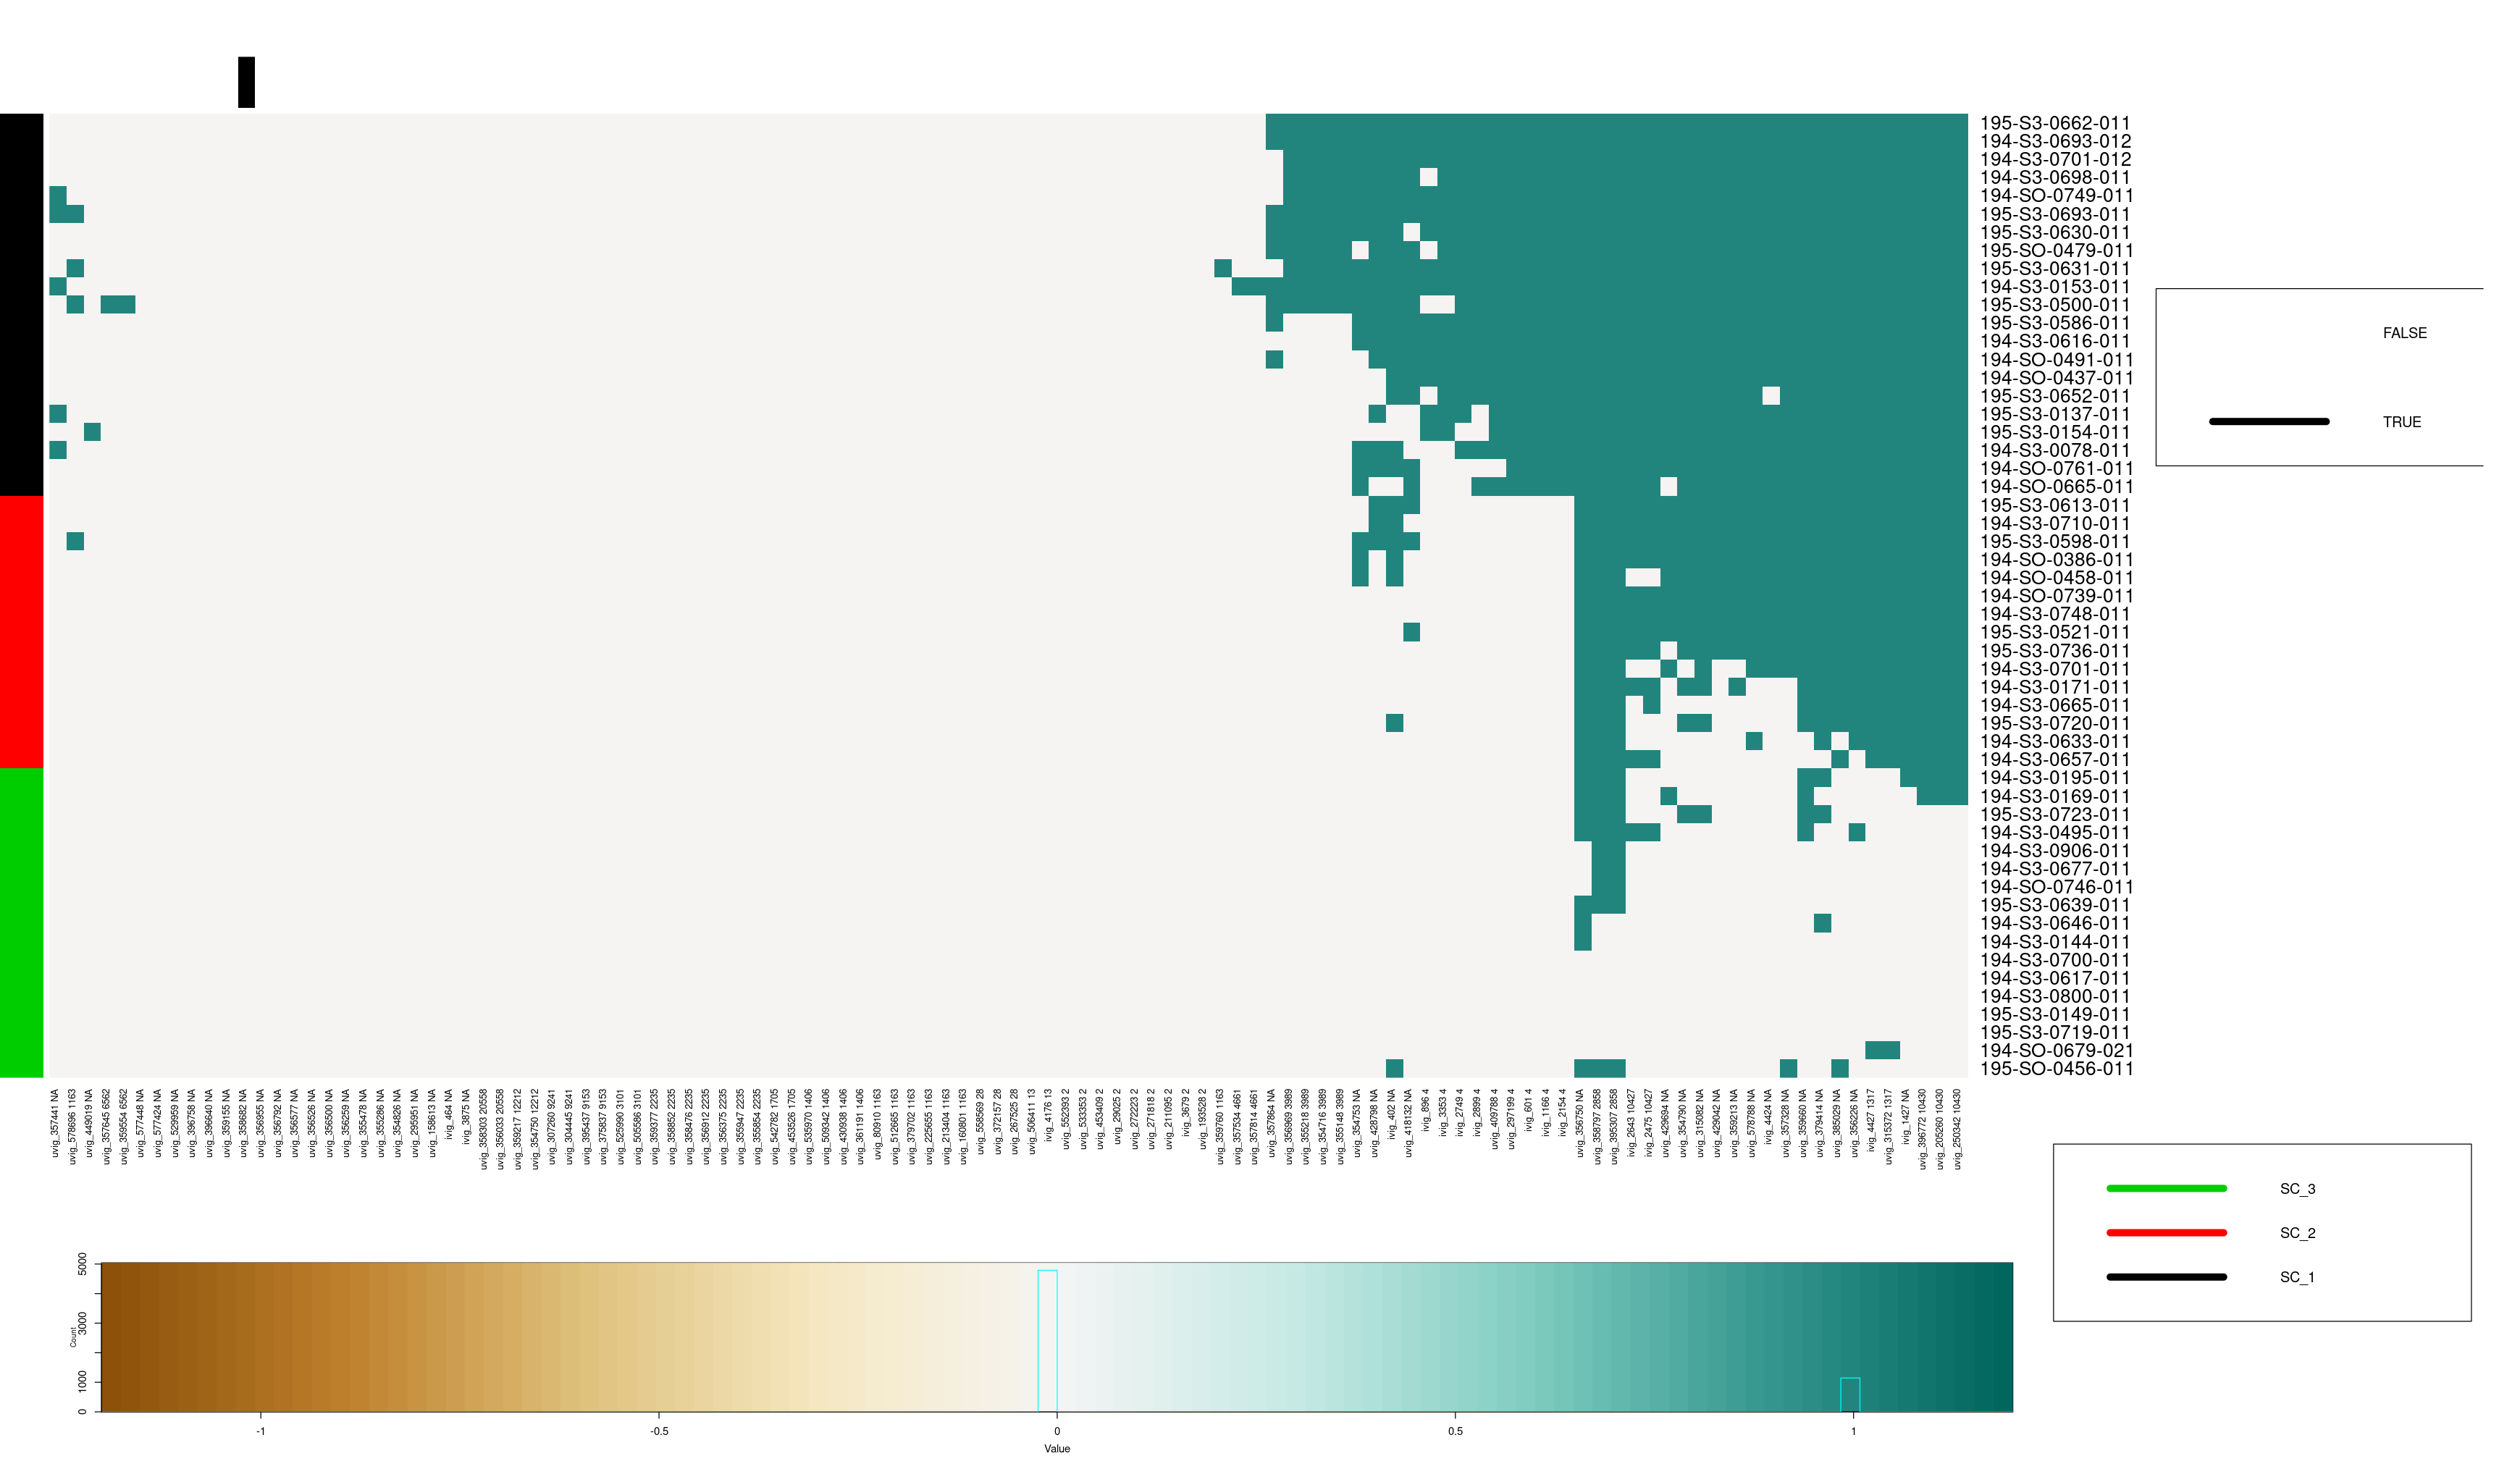

In [10]:
my_hm_funtion("prevotella","sample_cluster","pepsyn_7","vir_score_bin", max_vals = 1.2)

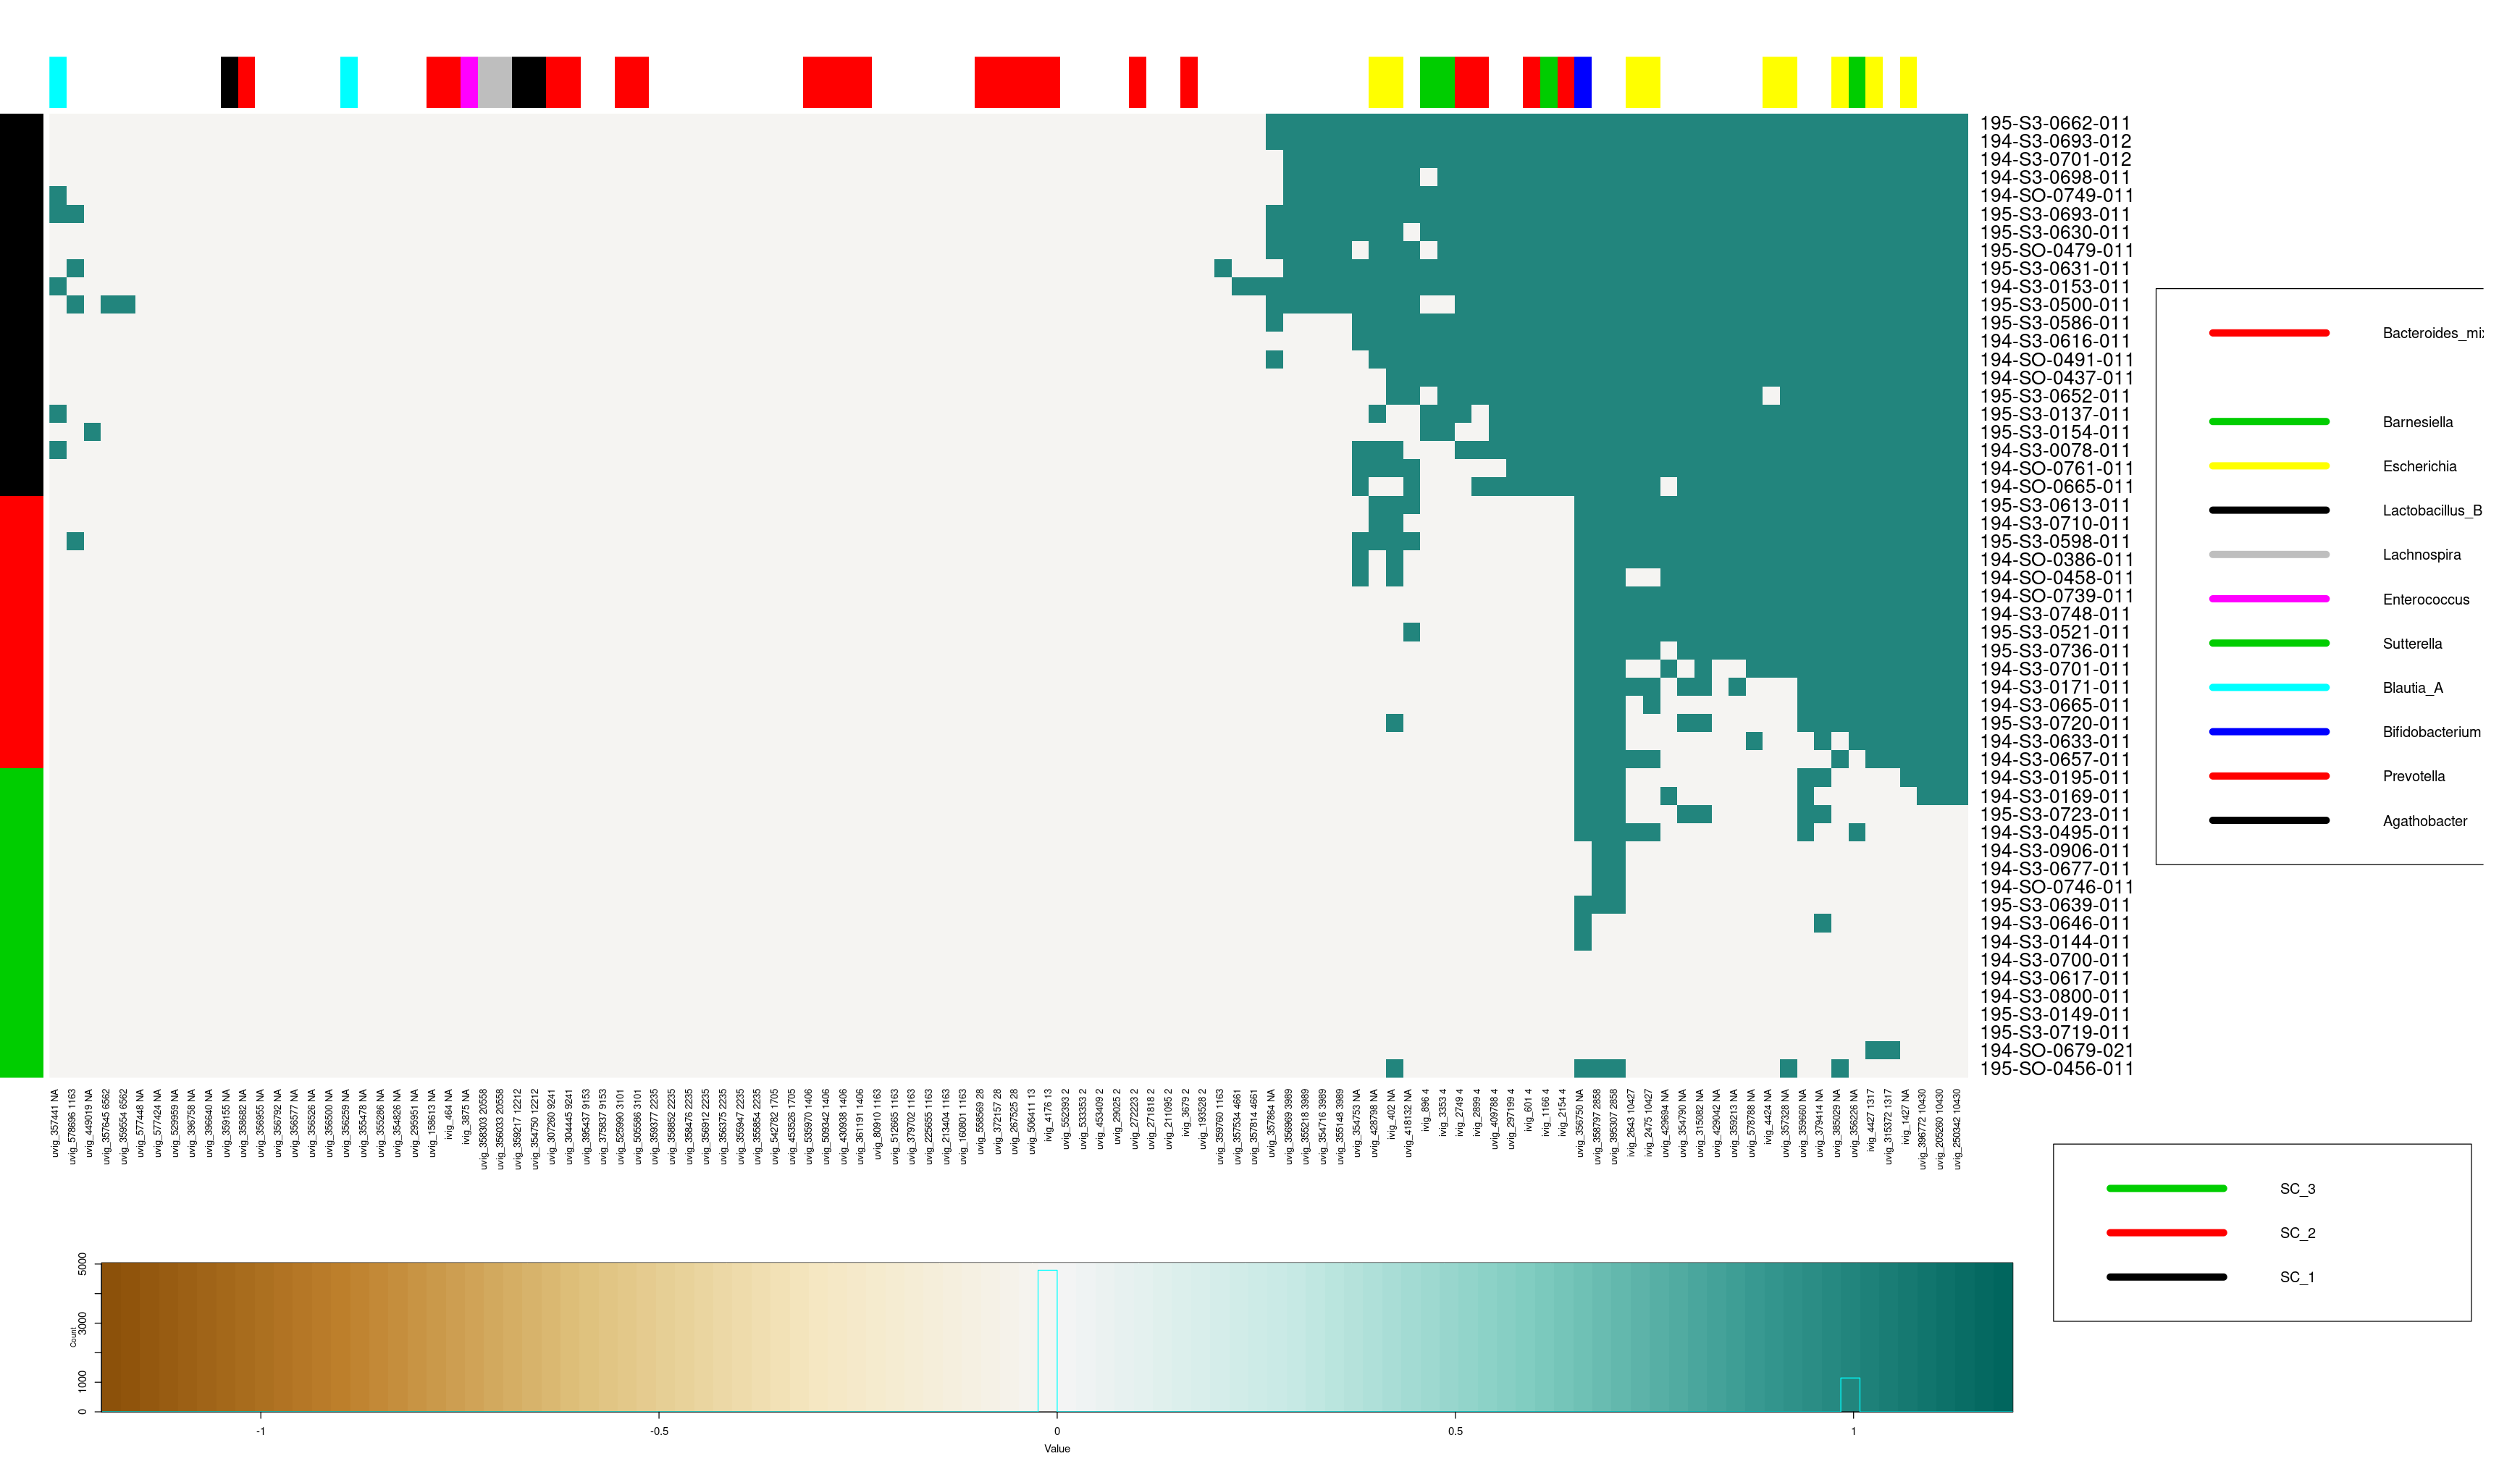

In [149]:
my_hm_funtion("Host_Genus","sample_cluster","pepsyn_7","vir_score_bin", max_vals = 1.2)

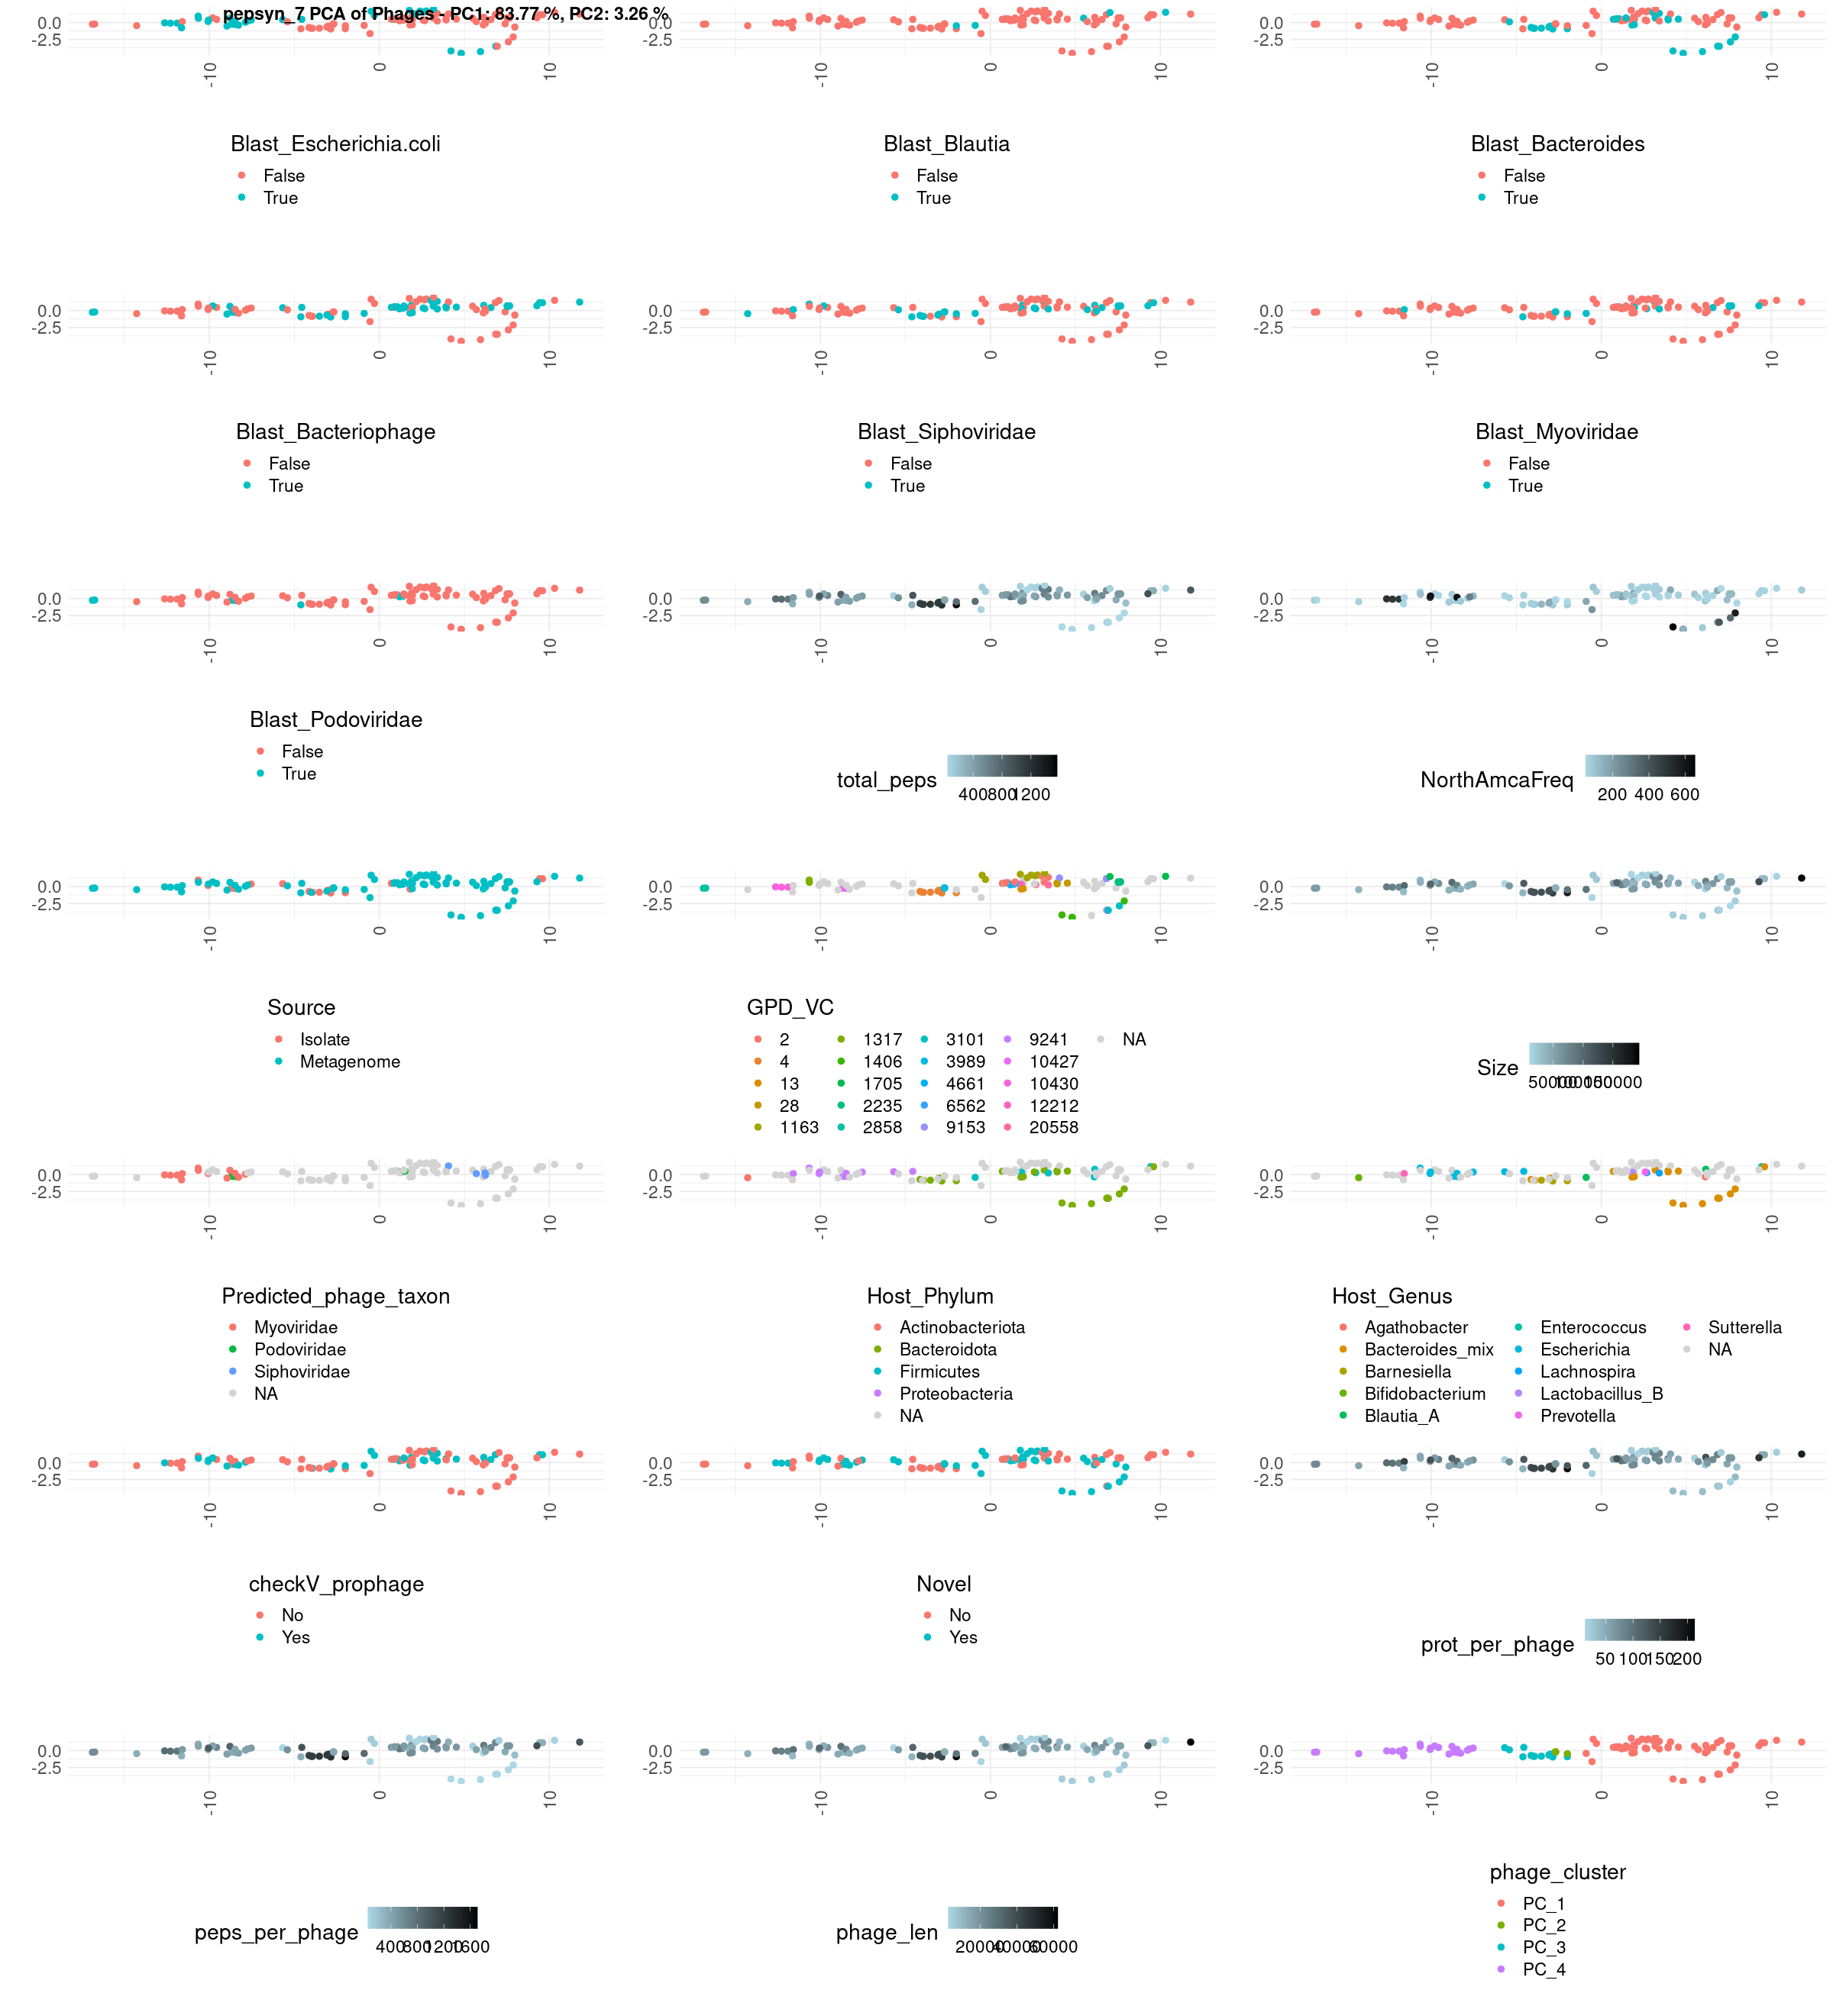

In [11]:
cols_of_interest = c(names(blast_anno),"total_peps","NorthAmcaFreq","Source","GPD_VC","Size","Predicted_phage_taxon","Host_Phylum","Host_Genus","checkV_prophage","Novel","prot_per_phage","peps_per_phage","phage_len","phage_cluster")
lib = "pepsyn_7"
score = "vir_score" 
plots_horizontal = 3
options(repr.plot.width=29, repr.plot.height=27)

my_pcaNtsne_function(cols_of_interest, lib, plots_horizontal, score, switch_phages = FALSE, switch_pca = TRUE, plotwid=20, plothei=22)
#my_pcaNtsne_function(cols_of_interest, lib, plots_horizontal, score, switch_phages = FALSE, switch_pca = FALSE, plotwid=20, plothei=22)

In [826]:
cols_of_interest = c("Blast_Bacteriophage","Blast_Escherichia.coli","NorthAmcaFreq","GPD_VC","Size","Predicted_phage_taxon","Host_Phylum","phage_cluster")
cols_of_interest = c("Blast_Escherichia.coli","Predicted_phage_taxon","Host_Phylum","phage_cluster")
lib = "pepsyn_7"
score = "vir_score"
plots_horizontal = 4

pdf("figures/PCA_pepsyn7.pdf", width = 10, height=4)
my_pcaNtsne_function(cols_of_interest, lib, plots_horizontal, score, switch_phages = FALSE, switch_pca = TRUE, plotwid=20, plothei=5)
dev.off()
pdf("figures/TSNE_pepsyn7.pdf", width = 10, height=4)
my_pcaNtsne_function(cols_of_interest, lib, plots_horizontal, score, switch_phages = FALSE, switch_pca = FALSE, plotwid=20, plothei=5)
dev.off()
lib = "dolphyn_7"
pdf("figures/PCA_dolphyn7.pdf", width = 10, height=4)
my_pcaNtsne_function(cols_of_interest, lib, plots_horizontal, score, switch_phages = FALSE, switch_pca = TRUE, plotwid=20, plothei=5)
dev.off()
pdf("figures/TSNE_dolphyn7.pdf", width = 10, height=4)
my_pcaNtsne_function(cols_of_interest, lib, plots_horizontal, score, switch_phages = FALSE, switch_pca = FALSE, plotwid=20, plothei=5)
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

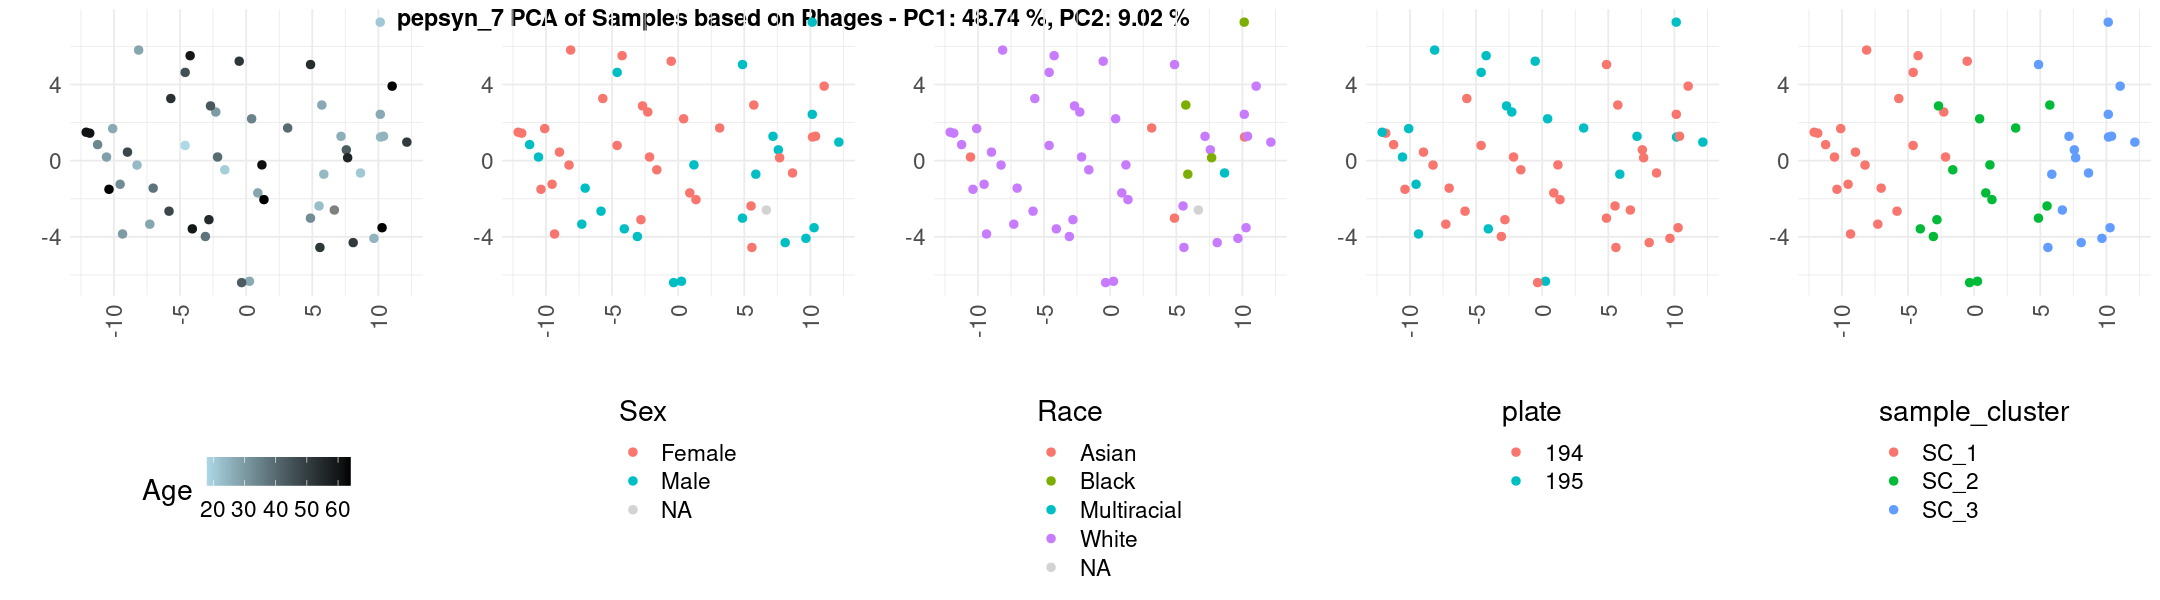

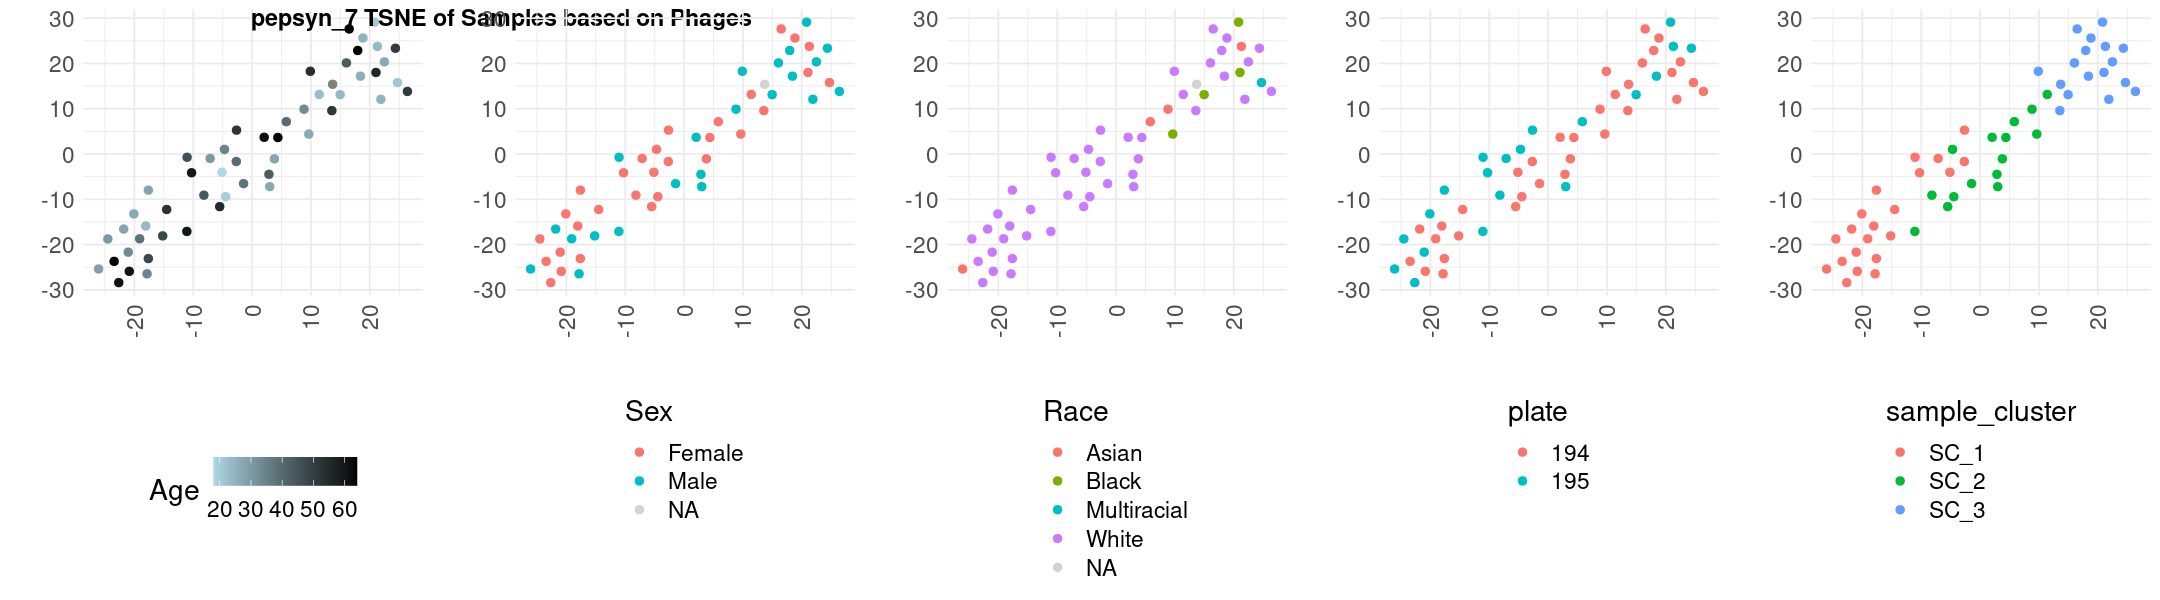

In [606]:
cols_of_interest = c("Age","Sex","Race", "plate", "sample_cluster") # "male_white_cluster", 
lib = "pepsyn_7"
score = "vir_score"#"cut_score" #"vir_score"

my_pcaNtsne_function(cols_of_interest, lib, plots_horizontal = 5, score, switch_phages = TRUE, switch_pca = TRUE, plotwid=18, plothei=5)
my_pcaNtsne_function(cols_of_interest, lib, plots_horizontal = 5, score, switch_phages = TRUE, switch_pca = FALSE, plotwid=18, plothei=5)

[1] "195-SO-0456-011" "194-SO-0679-021" "195-S3-0719-011" "195-S3-0149-011"
 [5] "194-S3-0800-011" "194-S3-0617-011" "194-S3-0700-011" "194-S3-0144-011"
 [9] "194-S3-0646-011" "195-S3-0639-011" "194-SO-0746-011" "194-S3-0677-011"
[13] "194-S3-0906-011" "194-S3-0495-011" "195-S3-0723-011" "194-S3-0169-011"
[17] "194-S3-0195-011" "194-S3-0657-011" "194-S3-0633-011" "195-S3-0720-011"
[21] "194-S3-0665-011" "194-S3-0171-011" "194-S3-0701-011" "195-S3-0736-011"
[25] "195-S3-0521-011" "194-S3-0748-011" "194-SO-0739-011" "194-SO-0458-011"
[29] "194-SO-0386-011" "195-S3-0598-011" "194-S3-0710-011" "195-S3-0613-011"
[33] "194-SO-0665-011" "194-SO-0761-011" "194-S3-0078-011" "195-S3-0154-011"
[37] "195-S3-0137-011" "195-S3-0652-011" "194-SO-0437-011" "194-SO-0491-011"
[41] "194-S3-0616-011" "195-S3-0586-011" "195-S3-0500-011" "194-S3-0153-011"
[45] "195-S3-0631-011" "195-SO-0479-011" "195-S3-0630-011" "195-S3-0693-011"
[49] "194-SO-0749-011" "194-S3-0698-011" "194-S3-0701-012" "194-S3-0693-012"
[53] "195-S3-0662-011"

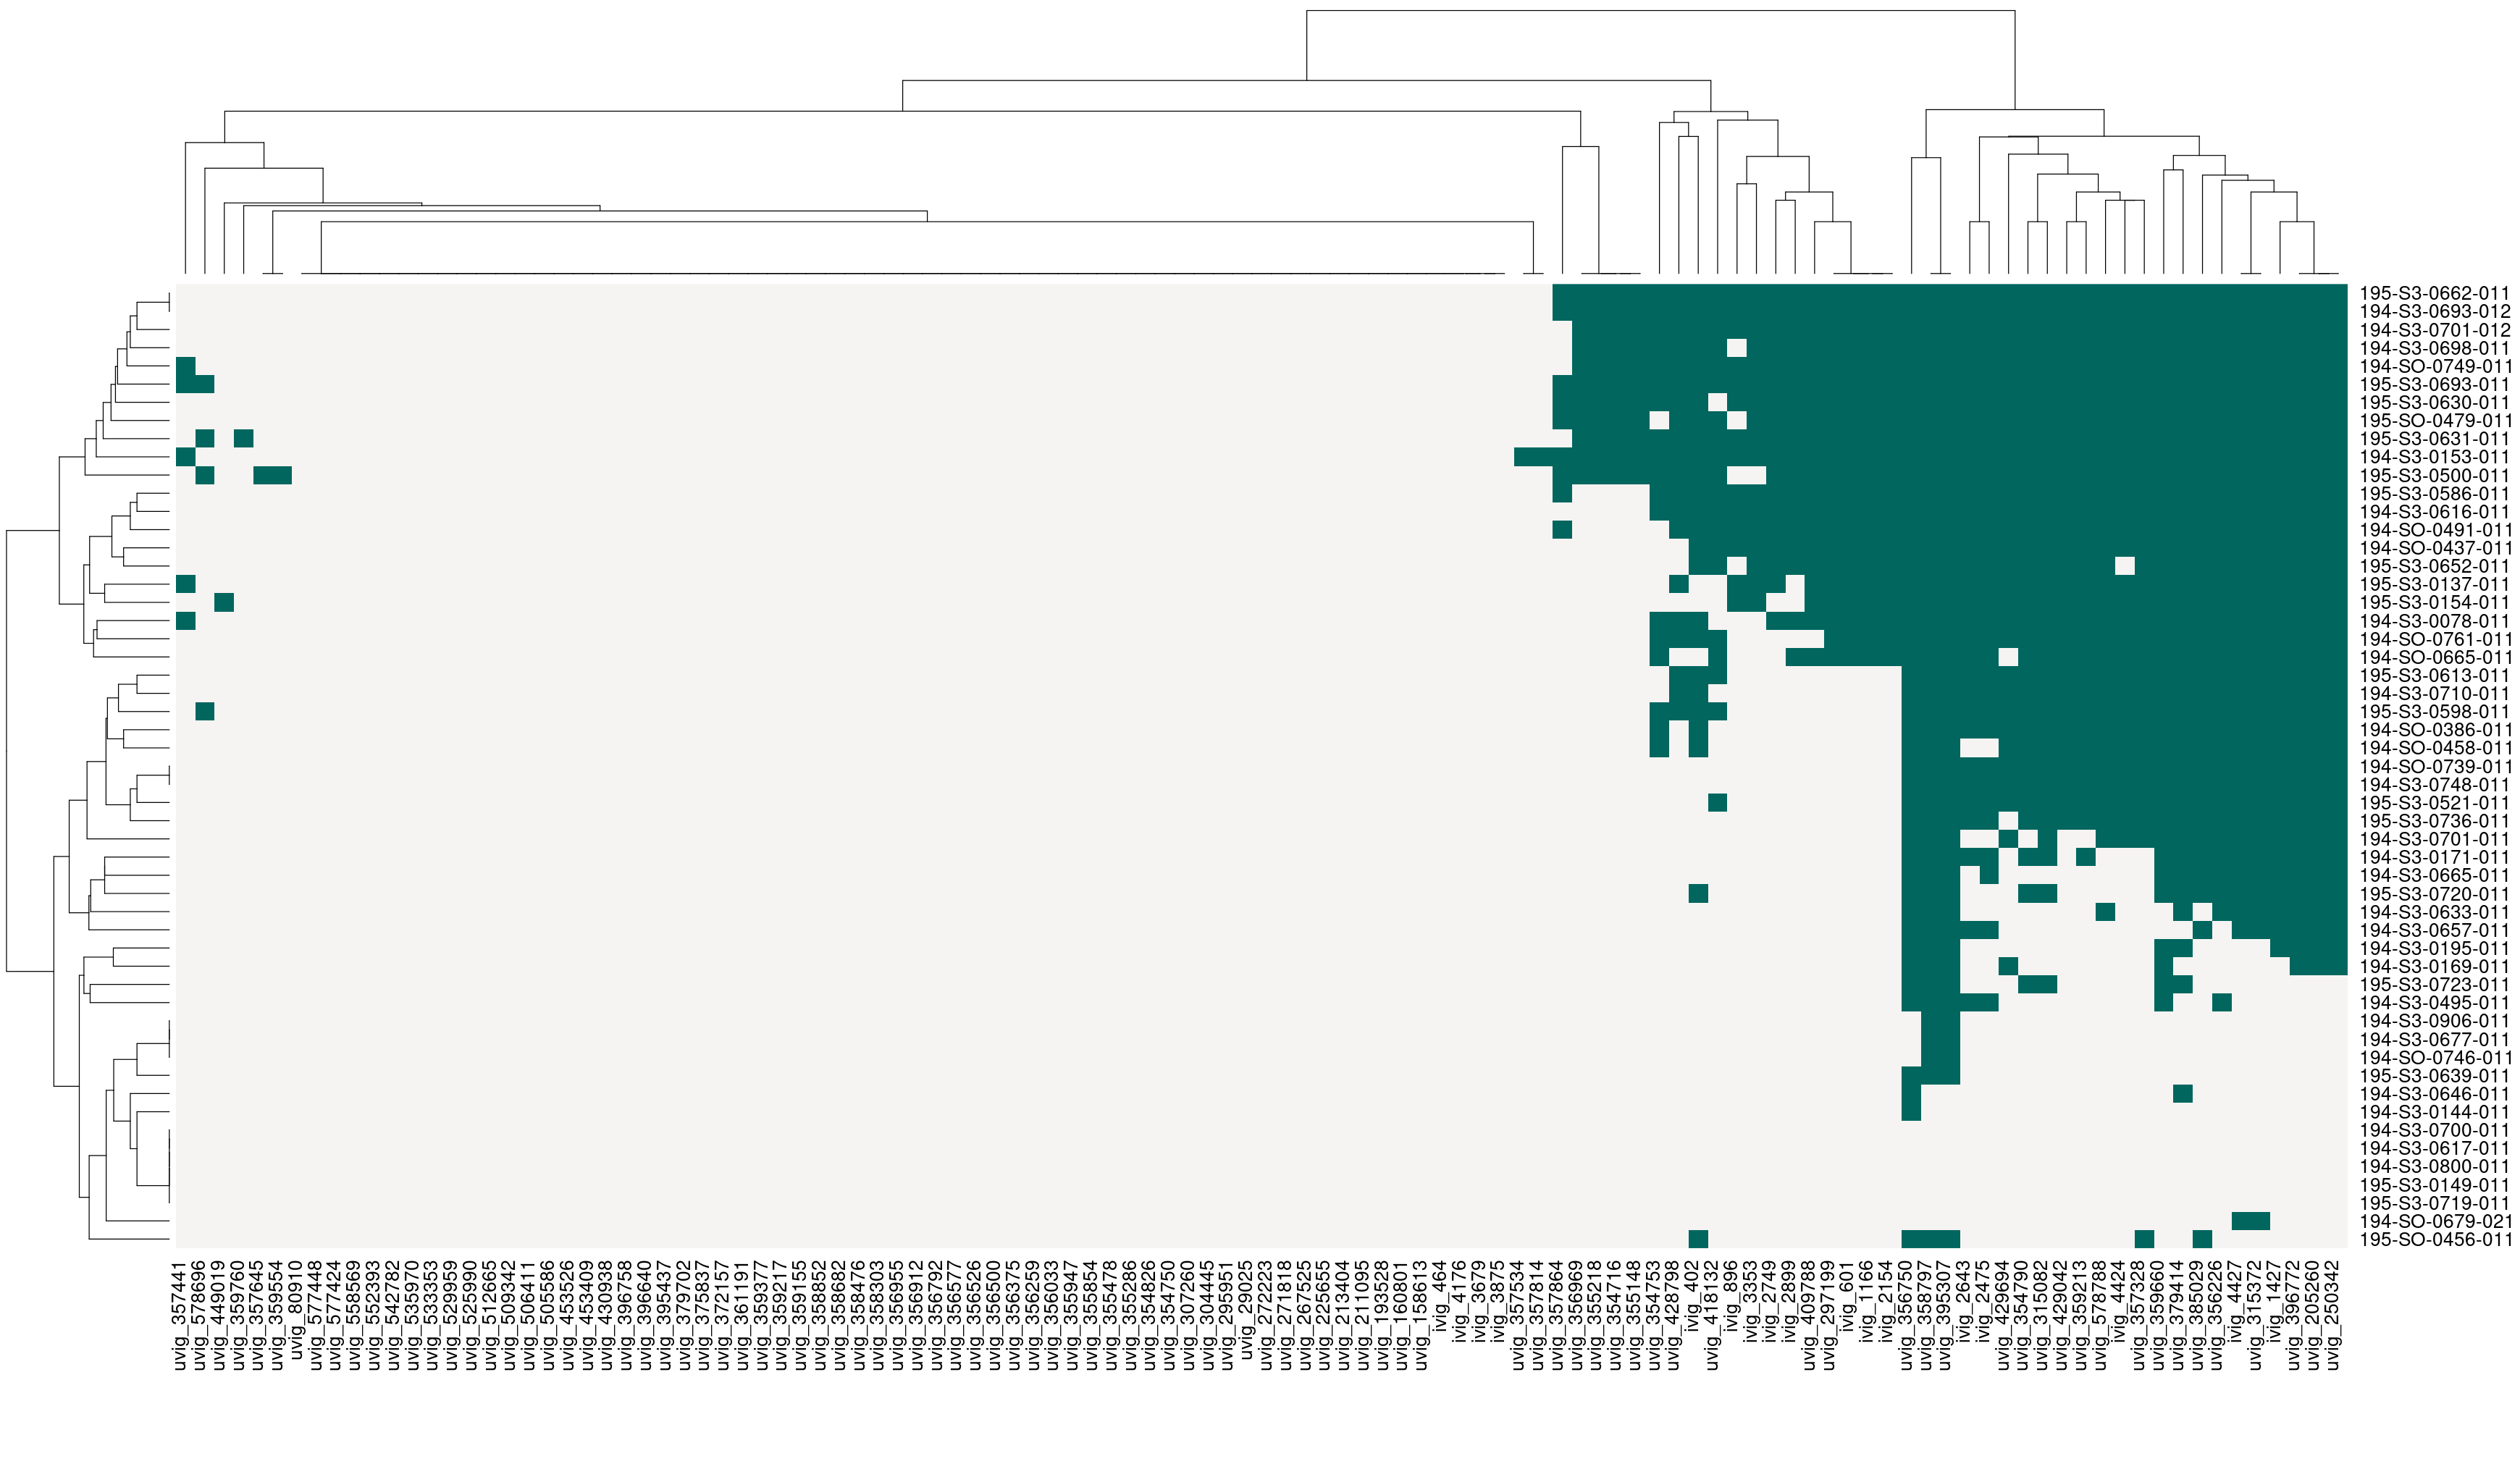

In [13]:
options(repr.plot.width=29, repr.plot.height=17)
hmcol = colorRampPalette(brewer.pal(9, "BrBG"))(100)

phar %>% subset(library == "pepsyn_7") %>%
mutate(taxon_id = factor(taxon_id, levels = unique(taxon_id))) -> hm_df

hm_df %>% dcast(sample ~ taxon_id, value.var="vir_score_bin") %>% 
column_to_rownames("sample") %>% as.matrix() -> hmmat

heatmap.2(hmmat, dendrogram ="both", trace="none",Rowv = TRUE, Colv = TRUE,
        scale= "none",
         hclustfun=function(c){hclust(c, method="mcquitty")},
         lmat = rbind(c(0,3),c(2,1),c(4,0)), lwid = c(0.3,4), lhei = c(0.5,2,0.1), margins=c(15,15), # layout sizes
         key.title =NA, symkey = FALSE, key=FALSE,
         col=hmcol, breaks = seq(-1, 1, length.out = 101), # key stuff
         cexRow = 2 , cexCol = 2                                   
) -> out

#colnames(hmmat)[out$colInd]
rownames(hmmat)[out$rowInd]

In [15]:
blank = data.frame(NorthAmcaFreq = 50:630, Size = mean(df$Size))

df %>% subset(library == "dolphyn_7") %>% glm(samples_reactive ~ NorthAmcaFreq + Size, data = .) %>%
predict(newdata = blank) %>% cbind(blank) %>% rename(samples_reactive = ".") %>% mutate(library = "dolphyn_7") -> lm_dol 

df %>% subset(library == "pepsyn_7") %>% glm(samples_reactive ~ NorthAmcaFreq + Size, data = .) %>%
predict(newdata = blank) %>% cbind(blank) %>% rename(samples_reactive = ".") %>% mutate(library = "pepsyn_7") %>% rbind(lm_dol) -> blank

In [34]:
data.frame(NorthAmcaFreq = 50:630, total_peps = mean(df$total_peps))

NorthAmcaFreq,total_peps
<int>,<dbl>
50,123.2614
51,123.2614
52,123.2614
53,123.2614
54,123.2614
⋮,⋮
626,123.2614
627,123.2614
628,123.2614


In [49]:
df %>% subset(library == "pepsyn_7") #%>% glm(samples_reactive ~ NorthAmcaFreq + total_peps, data = .) %>% summary

,taxon_id,NorthAmcaFreq,total_peps,library,samples_reactive
,<chr>,<int>,<int>,<fct>,<dbl>
1,ivig_1166,136,258,pepsyn_7,NA
2,ivig_1427,456,84,pepsyn_7,NA
3,ivig_2154,76,242,pepsyn_7,NA
4,ivig_2475,73,77,pepsyn_7,NA
5,ivig_2643,75,79,pepsyn_7,NA
⋮,⋮,⋮,⋮,⋮,⋮
84,uvig_552393,108,91,pepsyn_7,NA
85,uvig_558569,62,94,pepsyn_7,NA
86,uvig_577424,68,98,pepsyn_7,NA


In [73]:
phar %>% select(taxon_id, sample, library, vir_score, vir_score_bin, NorthAmcaFreq, total_peps) %>% 
group_by(taxon_id, library, NorthAmcaFreq, total_peps) %>% summarise_at(vars(vir_score_bin),funs(samples_reactive = sum)) %>%
mutate(library = factor(library, levels=c("pepsyn_7","dolphyn_7"))) -> temp
temp %>%
dcast(taxon_id + NorthAmcaFreq ~ library, value.var = "samples_reactive") %>%
subset(!is.na(dolphyn_7)) %>%
melt(id.vars = c("taxon_id","NorthAmcaFreq"), value.name = "samples_reactive", variable.name = "library") %>%
merge(temp) -> df

In [75]:
blank_dol = data.frame(NorthAmcaFreq = 50:630, total_peps = mean(df[df$library=="dolphyn_7",]$total_peps))
blank_pep = data.frame(NorthAmcaFreq = 50:630, total_peps = mean(df[df$library=="pepsyn_7",]$total_peps))

df %>% subset(library == "dolphyn_7") %>% glm(samples_reactive ~ NorthAmcaFreq + total_peps, data = .) %>%
predict(newdata = blank_dol) %>% cbind(blank_dol) %>% rename(samples_reactive = ".") %>% mutate(library = "dolphyn_7") -> lm_dol 

df %>% subset(library == "pepsyn_7") %>% glm(samples_reactive ~ NorthAmcaFreq + total_peps, data = .) %>%
predict(newdata = blank_pep) %>% cbind(blank_pep) %>% rename(samples_reactive = ".") %>% mutate(library = "pepsyn_7") %>% rbind(lm_dol) -> blank

In [76]:
blank

,samples_reactive,NorthAmcaFreq,total_peps,library
,<dbl>,<int>,<dbl>,<chr>
1,9.484408,50,553.0795,pepsyn_7
2,9.526424,51,553.0795,pepsyn_7
3,9.568440,52,553.0795,pepsyn_7
4,9.610456,53,553.0795,pepsyn_7
5,9.652472,54,553.0795,pepsyn_7
⋮,⋮,⋮,⋮,⋮
5771,6.036325,626,123.2614,dolphyn_7
5781,6.045894,627,123.2614,dolphyn_7
5791,6.055464,628,123.2614,dolphyn_7


null device 
          1

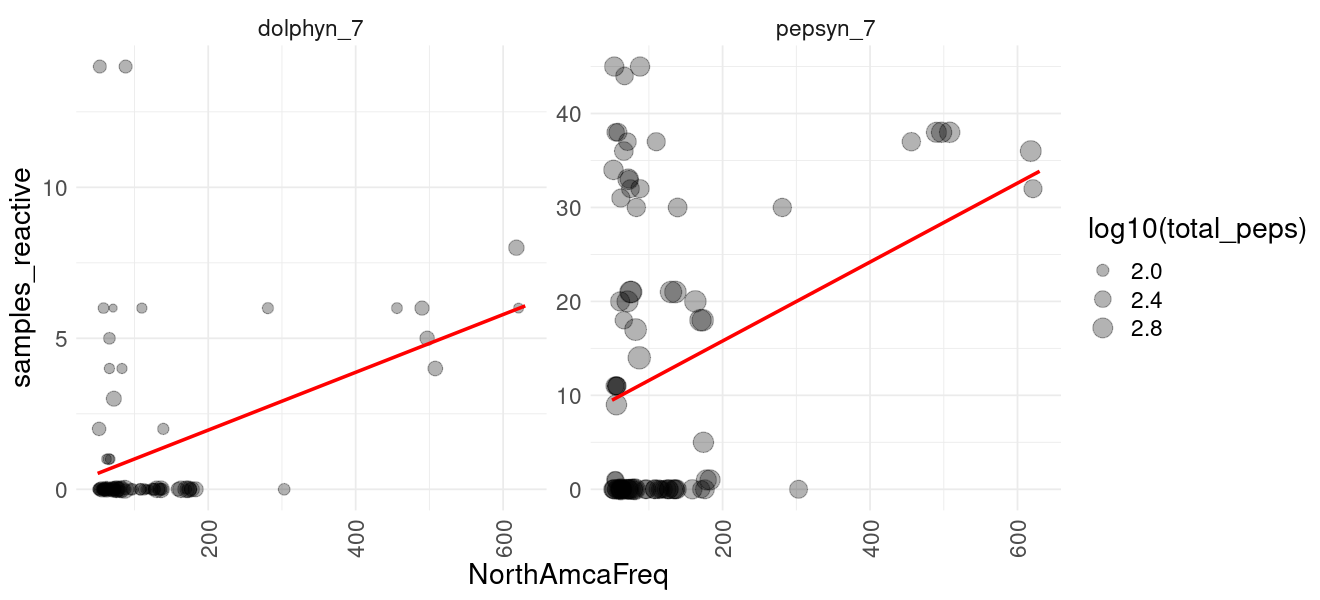

In [89]:
options(repr.plot.width=11, repr.plot.height=5)

phar %>% select(taxon_id, sample, library, vir_score, vir_score_bin, NorthAmcaFreq, total_peps) %>% 
group_by(taxon_id, library, NorthAmcaFreq, total_peps) %>% summarise_at(vars(vir_score_bin),funs(samples_reactive = sum)) %>%
mutate(library = factor(library, levels=c("pepsyn_7","dolphyn_7"))) -> temp
temp %>%
dcast(taxon_id + NorthAmcaFreq ~ library, value.var = "samples_reactive") %>%
subset(!is.na(dolphyn_7)) %>% 
melt(id.vars = c("taxon_id","NorthAmcaFreq"), value.name = "samples_reactive", variable.name = "library") %>%
merge(temp) -> df

df %>% ggplot(aes(NorthAmcaFreq, samples_reactive, size = log10(total_peps))) + geom_point(alpha = 0.3) + 
geom_line(data = blank, size = 1, color = "red") + facet_wrap(.~library, scales="free")
dev.off()

In [94]:
df %>% subset(library == "dolphyn_7") %>% glm(samples_reactive ~ NorthAmcaFreq + total_peps, data = .) %>% summary


Call:
glm(formula = samples_reactive ~ NorthAmcaFreq + total_peps, 
    data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.1426  -1.1667  -0.7534  -0.0108  13.3996  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)    0.849109   0.663848   1.279    0.204    
NorthAmcaFreq  0.009569   0.002291   4.178 7.11e-05 ***
total_peps    -0.006516   0.004557  -1.430    0.156    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 6.654761)

    Null deviance: 688.50  on 87  degrees of freedom
Residual deviance: 565.65  on 85  degrees of freedom
AIC: 421.47

Number of Fisher Scoring iterations: 2


In [139]:
df %>% subset(library == "pepsyn_7") %>% glm(samples_reactive ~ NorthAmcaFreq + Size, data = .) %>% summary



Call:
glm(formula = samples_reactive ~ NorthAmcaFreq + Size, data = .)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-19.929  -10.922   -9.247    9.244   35.568  

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)   6.292e+00  3.730e+00   1.687  0.09535 . 
NorthAmcaFreq 4.308e-02  1.310e-02   3.289  0.00147 **
Size          1.456e-05  4.820e-05   0.302  0.76337   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for gaussian family taken to be 216.5263)

    Null deviance: 20859  on 87  degrees of freedom
Residual deviance: 18405  on 85  degrees of freedom
AIC: 727.92

Number of Fisher Scoring iterations: 2


# Crossreactivity Analysis

In [10]:
inputfolder

ERROR: Error in eval(expr, envir, enclos): object 'inputfolder' not found


In [13]:
anno_pep = read.table("../data/DolphynLa_001_Universal.tsv", header = TRUE, sep = "\t", row.names = 2)
anno_pep = anno_pep[anno_pep$sublibrary != "validationDS",]
anno_pep %>% 
    select(c("sublibrary","pro_len", "pro_id", "pep_id","pos_start", "pos_end", "taxon_id", "pro_id_all")) %>% 
    mutate(across(where(is.factor), as.character)) -> anno_pep

# Hit Foldchange Data
#files <- list.files(inputfolder, pattern = "\\_DolphynLa_001_FoldChange.tsv$",  recursive = TRUE)
files <- list.files("../data/", pattern = "\\_DolphynLa_001_Hits_foldchange.tsv$",  recursive = TRUE)
fc <-  read.table(paste0("../data/",files[1]), header=TRUE, row.names = 1)
fc <- cbind(fc, read.table(paste0("../data/",files[2]), header=TRUE, row.names = 1))  
fc %>% select(!contains("BEADS_ONLY")) -> fc
fc = fc[rownames(anno_pep),]
lfc_org = log(fc)

# cleaning up sample names
anno_samples = data.frame(org = colnames(lfc_org))
anno_samples = cbind(anno_samples, str_split_fixed(anno_samples$org, "\\.",4))
anno_samples$sampleID = anno_samples$`4`
anno_samples %>% mutate(sampleID = gsub("Pre.Therapy_.", "", sampleID)) %>% mutate(sampleID = gsub(".20A20G.1", "", sampleID)) %>% 
                mutate(sampleID = gsub(".20A20G", "", sampleID)) %>% mutate(sampleID = gsub("VRC.", "", sampleID)) %>% 
                mutate(sampleID = gsub("IBD.Control.", "", sampleID)) %>% mutate(sampleID = gsub("_", "", sampleID)) -> anno_samples
rownames(anno_samples) = paste0(anno_samples$sampleID,anno_samples$`1`)
colnames(anno_samples) = c("original", "plate", "dataset", "group", "description", "sampleID")
colnames(lfc_org) = rownames(anno_samples)

In [41]:
phar %>% arrange(desc(vir_score)) %>% subset(library == "pepsyn_7") %>% head(10) %>% select(taxon_id) %>% unique %>% unlist -> top_score_phage
phar %>% arrange(desc(vir_score)) %>% subset(library == "pepsyn_7") %>% head(10) %>% select(sample) %>% unique %>% sapply(convert_samplenames) %>% as.list %>% unlist -> top_score_sample

In [27]:
phar %>% subset(library == "pepsyn_7") %>% subset(! taxon_id %in% c("uvig_250342","uvig_358797","uvig_205260")) %>% 
group_by(taxon_id) %>% 
summarise_at(vars(vir_score), funs(mean = mean, sum = sum, max = max)) %>%
arrange(desc(max)) %>% select(taxon_id) %>% unique %>% head(4) %>% unlist -> top_score_phage

phar %>% subset(library == "pepsyn_7") %>% 
group_by(sample) %>% 
summarise_at(vars(vir_score), funs(mean = mean, sum = sum, max = max)) %>%
arrange(desc(max)) %>% head(5) %>% select(sample) %>% unique %>% 
sapply(convert_samplenames) %>% as.list %>% unlist -> top_score_sample

ERROR: Error in match.fun(FUN): object 'convert_samplenames' not found


In [43]:
top_score_phage

taxon_id1     taxon_id2     taxon_id3     taxon_id4 
"uvig_395307" "uvig_356750" "uvig_396772" "uvig_356226"

In [44]:
# phages
check_for_crossreactivity = c(phage_cluster_4)
# long island
check_for_crossreactivity = c('uvig_356750','uvig_358797','uvig_395307')
# triangle family
check_for_crossreactivity = c('ivig_2643','ivig_2475')
# top ten vir_score
check_for_crossreactivity = top_score_phage

#samples
sample_cluster_crossreactivity = c('S3.0631.01X195','S3.0662.01X195','S3.0616.01X194','SO.0749.01X194','S3.0698.01X194','S3.0693.01X195','S3.0586.01X195','S3.0701.01.2X194','S3.0693.01.2X194')
# few highly reactive
sample_cluster_crossreactivity = c('S3.0631.01X195','S3.0662.01X195','SO.0665.01X194', "S3.0154.01X195")
# interesting in "long island"
sample_cluster_crossreactivity = c('S3.0144.01X194','S3.0646.01X194','S3.0639.01X195','SO.0746.01X194','S3.0677.01X194','S3.0906.01X194','S3.0495.01X194')
# triangle family
sample_cluster_crossreactivity = convert_samplenames(c('194-S3-0665-011','194-S3-0171-011'))
# top ten vir_score
sample_cluster_crossreactivity = top_score_sample

psl <- prep_crossreactivityPlot(lfc_org,sample_cluster_crossreactivity)

pdf 
  3

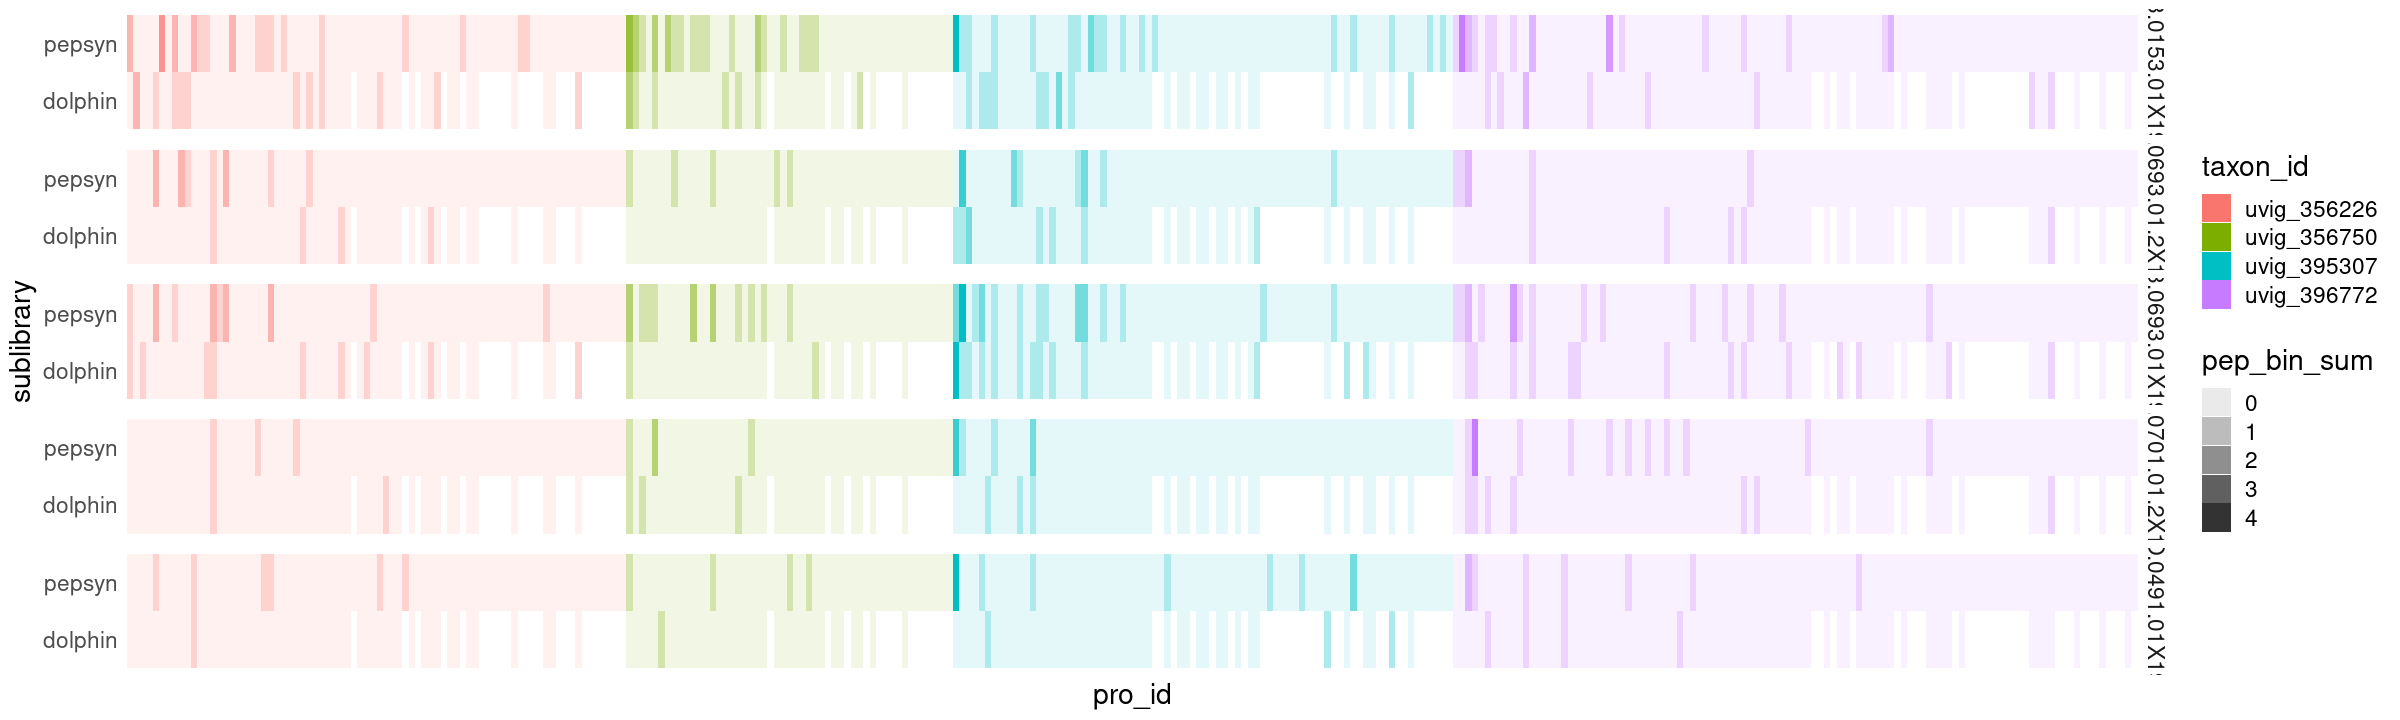

In [46]:
options(repr.plot.width=20, repr.plot.height=6)
#pdf("figures/top_phages_individual_response.pdf", width=22, height=6)
psl %>% subset(sublibrary == "dolphin" | sublibrary == "pepsyn") %>% 
#psl %>% subset(sublibrary == "pepsyn") %>% 
subset(taxon_id %in% check_for_crossreactivity) %>%
group_by(pro_id, taxon_id, pro_id_representative, sample, sublibrary) %>% 
summarise_at(vars(lfc, pep_bin), funs(mean = mean, sum = sum, n = n(), max = max)) %>%
merge(GPD_anno %>% select(taxon_id,GPD_VC)) %>% arrange(taxon_id, desc(lfc_n)) %>%
distinct(pro_id_representative,sample,sublibrary,taxon_id, .keep_all = TRUE) %>% #removing proteins that are identical on the same phage
mutate(pro_id_representative = factor(pro_id_representative, levels = unique(pro_id_representative))) %>%
mutate(pro_id = factor(pro_id, levels = unique(pro_id))) %>%
mutate(taxon_id = factor(taxon_id, levels = unique(taxon_id))) -> df

#df %>% ggplot(aes(pro_id, sample)) + geom_tile(aes(fill = taxon_id, alpha = pep_bin_sum)) + 
#  theme(axis.text.x=element_blank(), panel.grid.major.x = element_blank(), panel.grid.major.y = element_blank()) + facet_grid(sublibrary~.)
df %>% ggplot(aes(pro_id, sublibrary)) + geom_tile(aes(fill = taxon_id, alpha = pep_bin_sum)) + 
  theme(axis.text.x=element_blank(), panel.grid.major.x = element_blank(), panel.grid.major.y = element_blank()) + facet_grid(sample~.)
dev.off()

null device 
          1

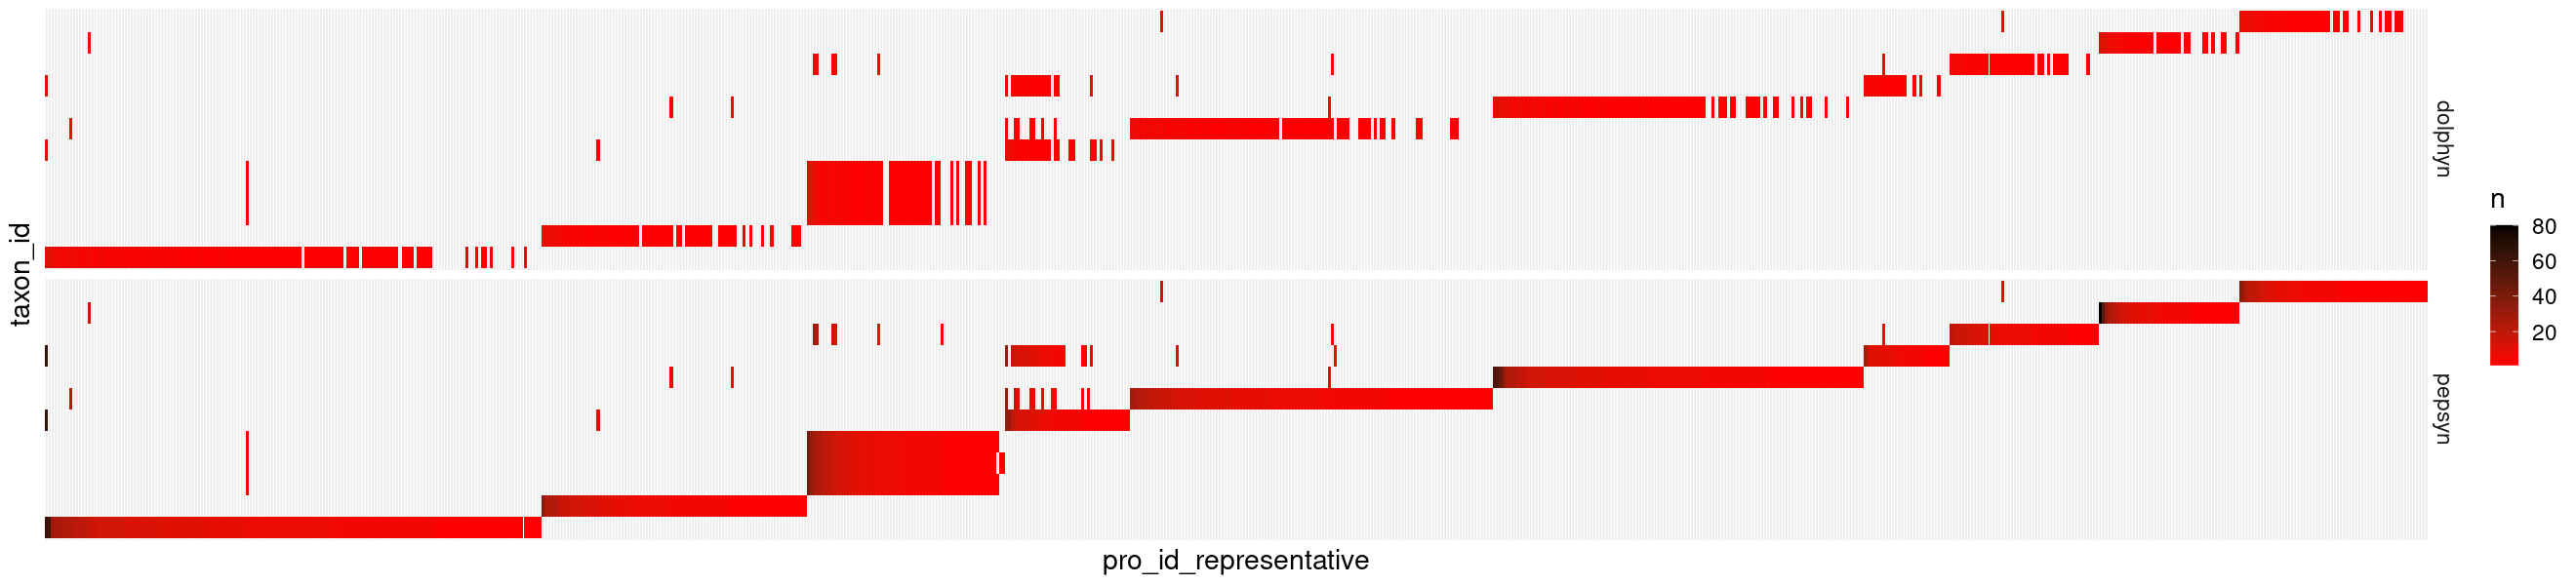

In [16]:
options(repr.plot.width=22, repr.plot.height=5)
#pdf("figures/library_comparison_proteins.pdf", width=22, height=5)
set.seed(12)
phar %>% select(taxon_id) %>% unique %>% sample_n(12) %>% unlist -> random_phage_set
psl <- prep_crossreactivityPlot(lfc_org,c('S3.0144.01X194'))

psl %>% subset(sublibrary == "dolphin" | sublibrary == "pepsyn") %>% 
mutate(sublibrary = gsub("dolphin", "dolphyn", sublibrary)) %>%
subset(taxon_id %in% random_phage_set) -> psl 

merge(psl, psl %>% ungroup %>% subset(sublibrary == "pepsyn") %>% select(pro_id_representative, taxon_id) %>% unique() %>% select(pro_id_representative) %>% 
table() %>% as.data.frame() %>% rename(pro_id_representative = ".") %>% rename(in_phages = "Freq")) %>%
group_by(pro_id, taxon_id, pro_id_representative, sample, sublibrary, in_phages) %>% 
summarise_at(vars(lfc, pep_bin), funs(mean = mean, sum = sum, n = n(), max = max)) %>%
rename(n=lfc_n)%>%
merge(GPD_anno %>% select(taxon_id,GPD_VC)) %>% arrange(taxon_id, desc(n), desc(in_phages),) %>%
distinct(pro_id_representative,sample,sublibrary,taxon_id, .keep_all = TRUE) %>%
mutate(pro_id_representative = factor(pro_id_representative, levels = unique(pro_id_representative))) %>%
mutate(taxon_id = factor(taxon_id, levels = unique(taxon_id))) %>%

ggplot(aes(pro_id_representative,taxon_id)) + geom_tile(aes(fill = n)) + scale_fill_gradient(low = "red", high = "black") + 
  theme(axis.text.x=element_blank(), axis.text.y=element_blank(), panel.grid.major.y = element_blank()) + facet_grid(sublibrary~.)
dev.off()

In [12]:
names(phar)

[1] "taxon_id"               "sample"                 "library"               
 [4] "sample_id"              "total_peps"             "score"                 
 [7] "score_norm"             "shape"                  "rate"                  
[10] "mean"                   "variance"               "vir_score"             
[13] "virus_fc"               "p_val"                  "hm_value"              
[16] "agg_score"              "cut_score"              "vir_score_cut"         
[19] "vir_score_bin"          "plate"                  "male_white_cluster"    
[22] "Age"                    "Sex"                    "Race"                  
[25] "prot_per_phage"         "peps_per_phage"         "phage_len"             
[28] "Blast_Escherichia.coli" "Blast_Blautia"          "Blast_Bacteroides"     
[31] "Blast_Bacteriophage"    "Blast_Siphoviridae"     "Blast_Myoviridae"      
[34] "Blast_Podoviridae"      "Source"                 "GPD_VC"                
[37] "Size"                   "Predicted_phage_taxon"  "checkV_prophage"       
[40] "Novel"                  "NorthAmcaFreq"          "Host_range_taxon"      
[43] "Host_Genus"             "Host_Phylum"            "p_val_re"              
[46] "sample_cluster"         "phage_cluster"          "bin_myoviridae"        
[49] "bin_Escherichia"

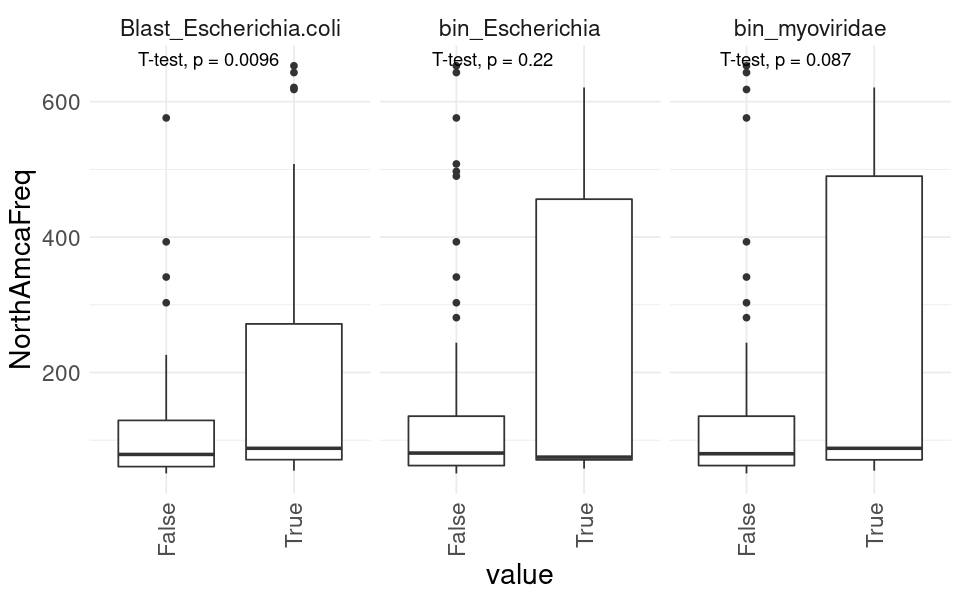

In [21]:
phar %>% select(taxon_id,Blast_Escherichia.coli,NorthAmcaFreq, bin_Escherichia, bin_myoviridae) %>% unique %>%
melt(id.vars=c("taxon_id","NorthAmcaFreq")) %>%
ggplot(aes(value,NorthAmcaFreq)) + geom_boxplot() + stat_compare_means(method="t.test")  + facet_grid(~variable)

In [36]:
options(repr.plot.width=10, repr.plot.height=4)

#pdf("figures/pharscoreMean_ecoli.pdf", width=8, height=5)
phar %>% select(taxon_id, Blast_Escherichia.coli, bin_Escherichia, bin_myoviridae, sample, vir_score, library) %>% 
group_by(library, taxon_id, Blast_Escherichia.coli, bin_Escherichia, bin_myoviridae) %>% 
summarise_at(vars(vir_score),funs(stat=mean)) %>% #max, mean, sum
melt(id.vars=c("taxon_id","stat","library"), variable.name="property") %>%
ggplot(aes(value,stat)) + geom_boxplot() + stat_compare_means()  + facet_grid(~property+library)
dev.off()

png 
  2

In [151]:
#a %>% subset(sublibrary=="pepsyn") %>% write.table("pepsyn_logHFC_demultiplexed.csv", sep=",")

In [152]:
# archive preprocessing for HITfc values into protein HM

lhfc_org -> lhfc
lhfc_org %>% select(all_of(sample_cluster_crossreactivity)) -> lhfc
# bind peptide information of interest
anno_pep %>% select(c("sublibrary", "pro_id", "pep_id", "taxon_id", "pro_id_all")) %>% 
    cbind(lhfc) %>% mutate(across(where(is.factor), as.character)) -> a
# deconvolute the protein representatives and duplicate the rows corresponsingly
a %>% select(pep_id,pro_id_all) %>% distinct() %>% 
    mutate(pro_id_all = gsub("[{} ]","",pro_id_all)) %>%
    mutate(pro_id_all = strsplit(pro_id_all,",")) -> protein_clusters_map
p = protein_clusters_map$pro_id_all
names(p) <- protein_clusters_map$pep_id
protein_clusters = stack(p)
a %>% merge(protein_clusters, by.x = 'pep_id', by.y = "ind", all = TRUE) %>% 
    rename(pro_id_representative = pro_id) %>% rename(pro_id = values) %>% select(-pro_id_all) -> a
a %>% select(-taxon_id) %>%  mutate(taxon_id = sub("_[^_]+$", "", pro_id)) -> a
# add summary values
a %>% select(contains("X194")) %>% {.>0} %>% rowSums() %>% cbind(a) %>% rename("p194_bin" = ".") -> a
a %>% select(contains("X195")) %>% {.>0} %>% rowSums() %>% cbind(a) %>% rename("p195_bin" = ".") -> a
a$igg_bin = a$p194_bin + a$p195_bin


a %>% select(contains("X194")) %>% rowSums() %>% cbind(a) %>% rename("p194_igg" = ".") -> a
a %>% select(contains("X195")) %>% rowSums() %>% cbind(a) %>% rename("p195_igg" = ".") -> a
a$igg = a$p194_igg + a$p195_igg

merge(a %>% select(pro_id_representative, taxon_id) %>% unique() %>% select(pro_id_representative) %>% table() %>% 
          as.data.frame() %>% rename(rep_id = ".") %>% rename(in_phages = "Freq"),
      a %>% select(pro_id_representative, pro_id, taxon_id) %>% unique() %>% select(pro_id_representative) %>% table() %>% 
          as.data.frame() %>% rename(rep_id = ".") %>% rename(no_proteins = "Freq")) -> proteins_in_phages

ERROR: Error in eval(expr, envir, enclos): object 'lhfc_org' not found


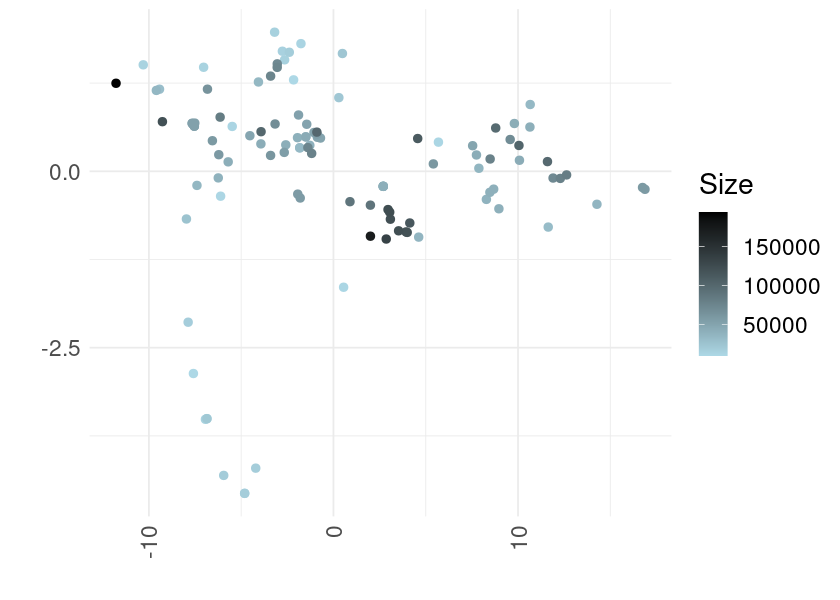

In [567]:
# archive single PCA if needed
options(repr.plot.width=7, repr.plot.height=5)

phar %>% subset(library == "pepsyn_7")  %>% 
select(Size, taxon_id, vir_score, sample) %>%
tidyr::spread("sample","vir_score") -> pca_df
pca_df %>% select(-Size, -taxon_id) %>% select(which(!colSums(., na.rm=TRUE) %in% 0)) %>% prcomp(center=TRUE, scale. = TRUE) -> pca 

cbind(data.frame(x = pca$x[,1], y = pca$x[,2]), pca_df %>% select(Size)) %>%
ggplot() + 
        geom_point(aes(x=x, y=y, color=Size), size = 2)+ 
        xlab("") + ylab("") + scale_color_gradient(low = "lightblue", high = "black")